In [1]:
import copy
import itertools as it
import random
import typing

from IPython.core.display import display, HTML
from nbmetalog import nbmetalog as nbm
import opytional as opyt
import pandas as pd
from scipy import stats as scipy_stats
import seaborn as sns
from tqdm import tqdm

import pylib

random.seed(1)

pylib.jupyter_hide_toggle()


In [2]:
nbm.print_metadata()

pylib.jupyter_hide_toggle()


context: ci
hostname: fv-az575-767
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: 04-incrementing-incidence-reservation-surface-with-safety-aligned-transition
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/04-incrementing-incidence-reservation-surface-with-safety-aligned-transition.ipynb
revision: null
session: 166435f8-3f8a-48c3-8663-81d7be7e5c68
timestamp: 2024-04-23T17:01:41Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
nbmetalog==0.2.6
opytional==0.1.0
pandas==1.5.2
scipy==1.10.1
seaborn==0.13.2
re==2.2.1
comm==0.1.3
logging==0.5.1.2
psutil==5.9.5
zmq==25.1.0
json==2.0.9
ipykernel==6.23.3


In [3]:
def get_num_sites_reserved_per_incidence_at_rank(rank: int) -> int:
    return pylib.bit_ceil(pylib.hanoi.get_max_hanoi_value_through_index(rank) + 1)


In [4]:
# test get_num_sites_reserved_per_incidence_at_rank
assert [get_num_sites_reserved_per_incidence_at_rank(rank) for rank in range(17)] == [
    # hanoi sequence (1-based):
    1,  # 1,
    2,  # 2,
    2,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 4,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    8,  # 5,
    8,  # 1,
]
pylib.jupyter_hide_toggle()


In [5]:
def get_num_incidence_reservations_at_rank(rank: int, surface_size: int) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    assert surface_size % reservation_size == 0
    num_reservations = surface_size // reservation_size
    return num_reservations


In [6]:
# test get_num_incidence_reservations_at_rank
assert [get_num_incidence_reservations_at_rank(rank, 64) for rank in range(17)] == [
    # hanoi sequence (1-based):
    64,  # 1,
    32,  # 2,
    32,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 4,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    8,   # 5,
    8,   # 1,
]

pylib.jupyter_hide_toggle()


In [7]:
def is_2x_reservation_eligible(hanoi_value: int, surface_size: int, rank: int) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    lb_inclusive = (
        pylib.hanoi.get_max_hanoi_value_through_index(rank) - reservation_width // 2 + 1
    )
    ub_exclusive = reservation_width // 2
    return lb_inclusive <= hanoi_value < ub_exclusive

pylib.jupyter_hide_toggle()


In [8]:
# test is_2x_reservation_eligible
# TODO

pylib.jupyter_hide_toggle()


In [9]:
def get_prev_invading_hanoi_value(hanoi_value: int, rank: int) -> typing.Optional[int]:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    degrading_reservation_width = reservation_width // 2

    if hanoi_value < degrading_reservation_width // 2:
        return hanoi_value + degrading_reservation_width // 2
    else:
        return None


In [10]:
assert get_prev_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) is None

assert get_prev_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) is None

assert get_prev_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) is None

assert get_prev_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == 3

pylib.jupyter_hide_toggle()


In [11]:
def is_hanoi_invader(hanoi_value: int, rank: int) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    return hanoi_value >= reservation_width // 2


In [12]:
assert not is_hanoi_invader(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invader(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)

assert not is_hanoi_invader(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)

assert not is_hanoi_invader(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)

pylib.jupyter_hide_toggle()


In [13]:
def is_hanoi_invaded(hanoi_value: int, rank: int) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    max_hanoi_value = pylib.hanoi.get_max_hanoi_value_through_index(rank)

    return (
        not is_hanoi_invader(hanoi_value, rank)
        and max_hanoi_value >= hanoi_value + reservation_width // 2
    )


In [14]:
assert not is_hanoi_invaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invaded(
    0,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invaded(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)

assert not is_hanoi_invaded(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invaded(
    0,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)

pylib.jupyter_hide_toggle()


In [15]:
def is_hanoi_invadable_and_uninvaded(hanoi_value: int, rank: int) -> bool:
    return (
        not is_hanoi_invader(hanoi_value, rank)
        and not is_hanoi_invaded(hanoi_value, rank)
    )


In [16]:
assert is_hanoi_invadable_and_uninvaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    2,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    0,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invadable_and_uninvaded(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    0,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invadable_and_uninvaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    5,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)
pylib.jupyter_hide_toggle()


In [17]:
def get_next_invading_hanoi_value(hanoi_value: int, rank: int) -> int:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    degrading_reservation_width = reservation_width // 2

    if hanoi_value < degrading_reservation_width:
        return hanoi_value + degrading_reservation_width * 2
    else:
        return hanoi_value + reservation_width * 2


In [18]:
assert get_next_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == 5

assert get_next_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == 11

assert get_next_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == 11

assert get_next_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == 9

assert get_next_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
) == 9

pylib.jupyter_hide_toggle()


In [19]:
def get_invading_hanoi_value(hanoi_value: int, rank: int) -> int:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    degrading_reservation_width = reservation_width // 2

    if hanoi_value < degrading_reservation_width:
        return hanoi_value + degrading_reservation_width
    else:
        return hanoi_value + reservation_width


In [20]:
assert get_invading_hanoi_value(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == 3

assert get_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == 7

assert get_invading_hanoi_value(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == 7

pylib.jupyter_hide_toggle()


In [21]:
def get_rank_of_hanoi_invasion(hanoi_value: int, rank: int) -> int:
    invading_hanoi_value = get_invading_hanoi_value(hanoi_value, rank)
    return pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        invading_hanoi_value,
        0,
    )


In [22]:
assert get_rank_of_hanoi_invasion(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(3, 0)

assert get_rank_of_hanoi_invasion(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(7, 0)

assert get_rank_of_hanoi_invasion(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(7, 0)

pylib.jupyter_hide_toggle()


In [23]:
def get_rank_of_next_hanoi_invasion(hanoi_value: int, rank: int) -> int:
    next_invading_hanoi_value = get_next_invading_hanoi_value(hanoi_value, rank)
    return pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        next_invading_hanoi_value,
        0,
    )


In [24]:
assert get_rank_of_next_hanoi_invasion(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)

assert get_rank_of_next_hanoi_invasion(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(11, 0)

assert get_rank_of_next_hanoi_invasion(
    3,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(11, 0)

assert get_rank_of_next_hanoi_invasion(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(9, 0)

assert get_rank_of_next_hanoi_invasion(
    1,
    pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(9, 0)

pylib.jupyter_hide_toggle()


In [25]:
def get_rank_of_prev_hanoi_invasion(
    hanoi_value: int, rank: int
) -> typing.Optional[int]:
    prev_invading_hanoi_value = get_prev_invading_hanoi_value(
        hanoi_value, rank
    )
    return opyt.apply_if(
        prev_invading_hanoi_value,
        lambda x: pylib.hanoi.get_index_of_hanoi_value_nth_incidence(x, 0),
    )


In [26]:
assert (
    get_rank_of_prev_hanoi_invasion(
        1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
    )
    is None
)

assert (
    get_rank_of_prev_hanoi_invasion(
        3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
    )
    is None
)

assert (
    get_rank_of_prev_hanoi_invasion(
        3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
    )
    is None
)

assert get_rank_of_prev_hanoi_invasion(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
) == pylib.hanoi.get_index_of_hanoi_value_nth_incidence(3, 0)

pylib.jupyter_hide_toggle()


In [27]:
def get_hanoi_incidences_until_invasion(hanoi_value: int, rank: int) -> int:
    invasion_rank = get_rank_of_hanoi_invasion(hanoi_value, rank)
    if invasion_rank > rank:
        hanoi_value_cadence = pylib.hanoi.get_hanoi_value_index_cadence(
            hanoi_value
        )
        return (invasion_rank - rank) // hanoi_value_cadence
    else:
        return 0


In [28]:
def get_upcoming_hanoi_invasion_value(hanoi_value: int, rank: int) -> int:
    rank = max(
        rank,
        pylib.hanoi.get_index_of_hanoi_value_nth_incidence(hanoi_value, 0),
    )

    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    if is_hanoi_invader(hanoi_value, rank) or is_hanoi_invaded(
        hanoi_value, rank
    ):
        return hanoi_value + reservation_width
    else:
        return hanoi_value + reservation_width // 2


In [29]:
def get_upcoming_hanoi_invasion_rank(hanoi_value: int, rank: int) -> int:
    upcoming_invasion_hanoi_value = get_upcoming_hanoi_invasion_value(
        hanoi_value, rank
    )
    upcoming_invasion_rank = (
        pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            upcoming_invasion_hanoi_value, 0
        )
    )
    return upcoming_invasion_rank


In [30]:
def get_regime_end_rank(hanoi_value: int, rank: int) -> int:
    return get_upcoming_hanoi_invasion_rank(hanoi_value, rank)


In [31]:
def get_regime_mx(hanoi_value: int, rank: int) -> int:
    if is_hanoi_invadable_and_uninvaded(hanoi_value, rank):
        return 2
    else:
        return 1


In [32]:
def get_regime_num_reservations_available(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    mx = get_regime_mx(hanoi_value, rank)
    return get_num_incidence_reservations_at_rank(rank, surface_size) * mx


In [33]:
def get_regime_reservation_downgrade_rank(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    cadence = pylib.hanoi.get_hanoi_value_index_cadence(hanoi_value)
    offset = pylib.hanoi.get_hanoi_value_index_offset(hanoi_value)
    big_tour_size = get_regime_num_reservations_available(
        hanoi_value,
        surface_size,
        rank,
    )
    big_tour_time = big_tour_size * cadence
    end_rank = get_regime_end_rank(hanoi_value, rank)
    assert end_rank

    #    16 big tour
    #    8 little tour

    #    64 end rank -> 56 downgrade rank
    #    65 end rank -> 56 downgrade rank
    #    72 end_rank -> 72 downgrade rank
    required_lag = big_tour_time // 2
    # oc is offset corrected
    end_rank_oc = end_rank - offset
    deadline_rank_oc = end_rank_oc - required_lag
    #
    #   call this tt_split |        | call this tt_above
    #########################################################
    #             |----tour time----|
    #             |        :        |
    #                           ^deadline rank
    #                      ^mapped to here
    #                                     ^ end_rank
    #########################################################
    #             |----tour time----|
    #             |        :        |        :        |
    #                                   ^deadline rank
    #                      ^mapped to here
    #                                              ^ end_rank
    tt_above_oc = (deadline_rank_oc + big_tour_time // 2 - 1) - (
        (deadline_rank_oc + big_tour_time // 2) % big_tour_time
    )
    tt_split_oc = tt_above_oc - big_tour_time // 2
    assert deadline_rank_oc - tt_split_oc <= big_tour_time

    downgrade_rank_oc = tt_split_oc
    downgrade_rank = downgrade_rank_oc + offset
    assert downgrade_rank <= end_rank
    assert big_tour_time // 2 <= end_rank - downgrade_rank <= big_tour_time + big_tour_time // 2
    if downgrade_rank >= 0:
        assert (
            (pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(hanoi_value, downgrade_rank))
            % big_tour_size
            == big_tour_size // 2
        )

    return downgrade_rank


In [34]:
def get_regime_num_reservations_provided(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    thresh = get_regime_reservation_downgrade_rank(
        hanoi_value, surface_size, rank
    )
    before_thresh_num = get_regime_num_reservations_available(
        hanoi_value,
        surface_size,
        rank,
    )
    if rank >= thresh:
        return before_thresh_num // 2
    else:
        return before_thresh_num


In [35]:
def get_deposition_site_at_rank(rank: int, surface_size: int) -> int:
    within_reservation_offset = pylib.hanoi.get_hanoi_value_at_index(rank)

    num_incidence_reservations = get_regime_num_reservations_provided(
        within_reservation_offset, surface_size, rank
    )

    reservation_index = (
        pylib.hanoi.get_hanoi_value_incidence_at_index(rank)
        % num_incidence_reservations
    )

    longevity_ordered_reservation_position = (
        # this is more correct in a theoretical sense, and does have some effect
        # but actual functional improvements relative to simpler naive/alternating
        # should be tested; it may not be worth the extra complexity
        pylib.longevity_ordering_piecewise_ascending.get_longevity_mapped_position_of_index(
            reservation_index,
            surface_size,
        )
    )

    res = longevity_ordered_reservation_position + within_reservation_offset
    assert res < surface_size
    return res


In [36]:
for surface_size_exp in range(2, 12):
    surface_size = 2**surface_size_exp
    print(f"{surface_size=}")
    res = (
        pylib.site_selection_eval.get_first_decreasing_hanoi_value_deposition(
            get_deposition_site_at_rank,
            surface_size=surface_size,
            num_generations=min(
                2**18, 2 ** (surface_size - 1) - 1
            ),
            progress_wrap=tqdm,
        )
    )
    assert res is None, res

    res = pylib.site_selection_eval.get_first_deposition_over_too_new_site(
        get_deposition_site_at_rank,
        get_regime_num_reservations_provided,
        pylib.longevity_ordering_piecewise_ascending.get_longevity_mapped_position_of_index,
        surface_size=surface_size,
        num_generations=min(
            2**18, 2 ** (surface_size - 1) - 1
        ),
        progress_wrap=tqdm,
    )
    assert res is None, res


surface_size=4


100%|██████████| 7/7 [00:00<00:00, 33747.27it/s]


surface_size=8


100%|██████████| 127/127 [00:00<00:00, 42696.11it/s]


surface_size=16


100%|██████████| 32767/32767 [00:00<00:00, 46953.59it/s]


surface_size=32


100%|██████████| 262144/262144 [00:06<00:00, 42718.43it/s]


surface_size=64


100%|██████████| 262144/262144 [00:06<00:00, 39042.26it/s]


surface_size=128


100%|██████████| 262144/262144 [00:06<00:00, 37839.22it/s]


surface_size=256


100%|██████████| 262144/262144 [00:08<00:00, 31000.14it/s]


surface_size=512


100%|██████████| 262144/262144 [00:12<00:00, 21635.03it/s]


surface_size=1024


100%|██████████| 262144/262144 [00:19<00:00, 13633.43it/s]


surface_size=2048


100%|██████████| 262144/262144 [00:35<00:00, 7380.75it/s]


100%|██████████| 500/500 [00:00<00:00, 52451.09it/s]


,differentia,hanoi value,rank,site,deposition depth,deposition rank
0,1,0,0,0,0,0
1,0,-1,0,1,1,-1
2,1,-1,0,2,1,-1
3,0,-1,0,3,1,-1
4,1,-1,0,4,1,-1
...,...,...,...,...,...,...
7995,0,3,499,11,28,471
7996,1,4,499,12,4,495
7997,0,5,499,13,20,479
7998,1,6,499,14,52,447


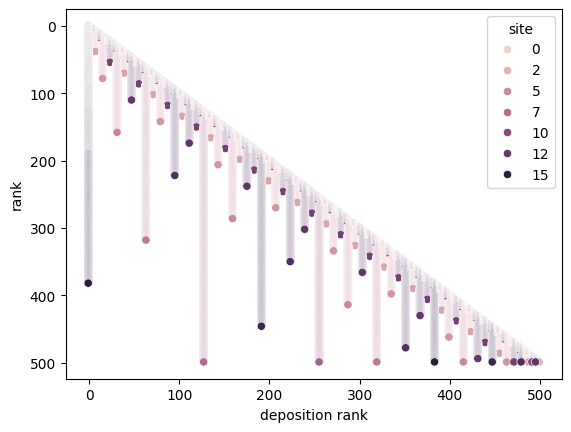

In [37]:
# test visualization

surface_size = 16
num_generations = 500

surface_history_df = pylib.site_selection_eval.make_surface_history_df(
    get_deposition_site_at_rank,
    surface_size=surface_size,
    num_generations=num_generations,
    progress_wrap=tqdm,
)
display(surface_history_df)

sns.scatterplot(
    data=surface_history_df,
    x="deposition rank",
    y="rank",
    hue="site",
).invert_yaxis()


In [38]:
pylib.jupyter_hide_toggle()

# test get_deposition_site_at_rank
# **needs to be updated**
# assert [get_deposition_site_at_rank(rank, 64) for rank in range(23)] == [
#          # num_reservations
#          #     # hanoi sequence (0-based):
#     0,   # 64, # 0,
#     1,   # 32, # 1,
#     32,  # 32, # 0,
#     2,   # 16, # 2,
#     16,  # 16, # 0,
#     33,  # 16, # 1,
#     48,  # 16, # 0,
#     3,   # 16, # 3,
#     8,   # 16, # 0,
#     17,  # 16, # 1,
#     24,  # 16, # 0,
#     34,  # 16, # 2,
#     40,  # 16, # 0,
#     49,  # 16, # 1,
#     56,  # 16, # 0,
#     4,   # 8,  # 4,
#     0,   # 8,  # 0,
#     9,   # 8,  # 1,
#     32,  # 8,  # 0,
#     18,  # 8,  # 2,
#     16,  # 8,  # 0,
#     25,  # 8,  # 1,
#     48,  # 8,  # 0,
# ]

# assert [get_deposition_site_at_rank(rank, 16) for rank in range(21)] == [
#         # num_reservations
#         #     # hanoi sequence (0-based):
#     0,  # 16, # 0,
#     1,  # 8,  # 1,
#     8,  # 8,  # 0,
#     2,  # 4,  # 2,
#     4,  # 4,  # 0,
#     9,  # 4,  # 1,
#     12, # 4,  # 0,
#     3,  # 4,  # 3,
#     0,  # 4,  # 0,
#     5,  # 4,  # 1,
#     8,  # 4,  # 0,
#     10, # 4,  # 2,
#     4,  # 4,  # 0,
#     13, # 4,  # 1,
#     12, # 4,  # 0,
#     4,  # 2,  # 4,
#     0,  # 2,  # 0,
#     1,  # 2,  # 1,
#     8,  # 2,  # 0,
#     6,  # 2,  # 2,
#     0,  # 2,  # 0,
# ]


In [39]:
def is_site_reservation_holdover_at_rank(
    site: int, surface_size: int, rank: int
) -> bool:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    within_reservation_offset = site % reservation_size

    return (
        within_reservation_offset
        > pylib.hanoi.get_max_hanoi_value_through_index(rank)
    )


In [40]:
# test get_hanoi_value_of_site

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 0  # 0,  # 16, # 0,
for rank in range(3):
    assert [
        is_site_reservation_holdover_at_rank(site, 16, rank)
        for site in range(16)
    ] == [False] * 16

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 3  # 2,  # 4,  # 2,
# 4  # 4,  # 4,  # 0,
# 5  # 9,  # 4,  # 1,
# 6  # 12, # 4,  # 0,
for rank in range(3, 7):
    assert [
        is_site_reservation_holdover_at_rank(site, 16, rank)
        for site in range(16)
    ] == [
        False,
        False,
        False,
        True,
    ] * 4

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 7  # 3,  # 4,  # 3,
# 8  # 0,  # 4,  # 0,
# 9  # 5,  # 4,  # 1,
# 10 # 8,  # 4,  # 0,
# 11 # 10, # 4,  # 2,
# 12 # 4,  # 4,  # 0,
# 13 # 13, # 4,  # 1,
# 14 # 12, # 4,  # 0,
for rank in range(7, 14):
    assert [
        is_site_reservation_holdover_at_rank(site, 16, rank)
        for site in range(16)
    ] == [False] * 16

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 15 # 4,  # 2,  # 4,
# 16 # 0,  # 2,  # 0,
# 17 # 1,  # 2,  # 1,
# 18 # 8,  # 2,  # 0,
# 19 # 6,  # 2,  # 2,
# 20 # 0,  # 2,  # 0,
for rank in range(15, 21):
    assert [
        is_site_reservation_holdover_at_rank(site, 16, rank)
        for site in range(16)
    ] == [
        False,
        False,
        False,
        False,
        False,
        True,
        True,
        True,
    ] * 2

pylib.jupyter_hide_toggle()


In [41]:
def get_hanoi_value_of_site_at_rank(
    site: int, surface_size: int, rank: int
) -> int:
    is_reservation_holdover = is_site_reservation_holdover_at_rank(
        site, surface_size, rank
    )

    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    if is_reservation_holdover:
        reservation_size //= 2

    return site % reservation_size

pylib.jupyter_hide_toggle()


In [42]:
# test get_hanoi_value_of_site

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 0  # 0,  # 16, # 0,
assert [
    get_hanoi_value_of_site_at_rank(site, 16, 0) for site in range(16)
] == [0] * 16

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 1  # 1,  # 8,  # 1,
# 2  # 8,  # 8,  # 0,
for rank in 1, 2:
    assert [
        get_hanoi_value_of_site_at_rank(site, 16, rank) for site in range(16)
    ] == [
        0,
        1,
    ] * 8

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 3  # 2,  # 4,  # 2,
# 4  # 4,  # 4,  # 0,
# 5  # 9,  # 4,  # 1,
# 6  # 12, # 4,  # 0,
for rank in range(3, 7):
    assert [
        get_hanoi_value_of_site_at_rank(site, 16, rank) for site in range(16)
    ] == [
        0,
        1,
        2,
        1,
    ] * 4

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 7  # 3,  # 4,  # 3,
# 8  # 0,  # 4,  # 0,
# 9  # 5,  # 4,  # 1,
# 10 # 8,  # 4,  # 0,
# 11 # 10, # 4,  # 2,
# 12 # 4,  # 4,  # 0,
# 13 # 13, # 4,  # 1,
# 14 # 12, # 4,  # 0,
for rank in range(7, 14):
    assert [
        get_hanoi_value_of_site_at_rank(site, 16, rank) for site in range(16)
    ] == [
        0,
        1,
        2,
        3,
    ] * 4

# rank
#    # deposition site
#    #     # num_reservations
#    #     #     # hanoi sequence (0-based):
# 15 # 4,  # 2,  # 4,
# 16 # 0,  # 2,  # 0,
# 17 # 1,  # 2,  # 1,
# 18 # 8,  # 2,  # 0,
# 19 # 6,  # 2,  # 2,
# 20 # 0,  # 2,  # 0,
for rank in range(15, 21):
    assert [
        get_hanoi_value_of_site_at_rank(site, 16, rank) for site in range(16)
    ] == [
        0,
        1,
        2,
        3,
        4,
        1,
        2,
        3,
    ] * 2

pylib.jupyter_hide_toggle()


In [43]:
def get_reservation_index_of_site_at_rank(
    site: int, surface_size: int, rank: int
) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    num_incidence_reservations = get_num_incidence_reservations_at_rank(
        rank, surface_size
    )

    is_reservation_holdover = is_site_reservation_holdover_at_rank(
        site, surface_size, rank
    )
    if is_reservation_holdover:
        reservation_size //= 2
        num_incidence_reservations *= 2

    longevity_ordered_reservation_position = site // reservation_size

    reservation_index = pylib.longevity_ordering_piecewise_ascending.get_longevity_index_of_mapped_position(
        longevity_ordered_reservation_position,
        num_incidence_reservations,
        polarity=True,
    )
    return reservation_index

pylib.jupyter_hide_toggle()


In [44]:
pylib.jupyter_hide_toggle()

# test get_reservation_index_of_site_at_rank
# **needs to be updated**
# assert [get_reservation_index_of_site_at_rank(site, 16, 0) for site in range(16)] == [
#     0,
#     8,
#     4,
#     9,
#     2,
#     10,
#     5,
#     11,
#     1,
#     12,
#     6,
#     13,
#     3,
#     14,
#     7,
#     15,
# ]

# for rank in 1, 2:
#     assert [get_reservation_index_of_site_at_rank(site, 16, rank) for site in range(16)] == [
#         0,
#         0,
#         4,
#         4,
#         2,
#         2,
#         5,
#         5,
#         1,
#         1,
#         6,
#         6,
#         3,
#         3,
#         7,
#         7,
#     ]

# for rank in range(3, 7):
#     assert [get_reservation_index_of_site_at_rank(site, 16, rank) for site in range(16)] == [
#         0,
#         0,
#         0,
#         4,
#         2,
#         2,
#         2,
#         5,
#         1,
#         1,
#         1,
#         6,
#         3,
#         3,
#         3,
#         7,
#     ]

# for rank in range(7, 14):
#     assert [get_reservation_index_of_site_at_rank(site, 16, rank) for site in range(16)] == [
#         0,
#         0,
#         0,
#         0,
#         2,
#         2,
#         2,
#         2,
#         1,
#         1,
#         1,
#         1,
#         3,
#         3,
#         3,
#         3,
#     ]

# for rank in range(15, 21):
#     assert [get_reservation_index_of_site_at_rank(site, 16, 15) for site in range(16)] == [
#         0,
#         0,
#         0,
#         0,
#         0,
#         2,
#         2,
#         2,
#         1,
#         1,
#         1,
#         1,
#         1,
#         3,
#         3,
#         3,
#     ]


In [45]:
def get_hanoi_incidence_of_site_at_rank(
    site: int, surface_size: int, rank: int
) -> int:
    # this function deals with incidence wraparound over number of reservations
    hanoi_value = get_hanoi_value_of_site_at_rank(site, surface_size, rank)
    incidence_count = (
        pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            hanoi_value,
            rank,
        )
    )
    incidence_count = max(incidence_count, 1)
    max_incidence = incidence_count - 1

    num_incidence_reservations_naive = get_num_incidence_reservations_at_rank(
        rank, surface_size
    )
    is_site_reservation_holdover_at_rank_ = is_2x_reservation_eligible(
        hanoi_value,
        surface_size,
        rank,
    )
    num_incidence_reservations = (
        num_incidence_reservations_naive
        * (is_site_reservation_holdover_at_rank_ + 1)
    )

    reservation_index = get_reservation_index_of_site_at_rank(
        site, surface_size, rank
    )
    assert reservation_index < num_incidence_reservations

    if max_incidence >= num_incidence_reservations:
        excess_incidence = (
            max_incidence - reservation_index
        ) % num_incidence_reservations
        candidate_incidence = max_incidence - excess_incidence
        candidate_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            hanoi_value,
            candidate_incidence,
        )
        assert candidate_rank <= rank
        if candidate_rank == rank:
            return candidate_incidence
        else:
            return get_hanoi_incidence_of_site_at_rank(
                site, surface_size, candidate_rank
            )
    else:
        return reservation_index

pylib.jupyter_hide_toggle()


In [46]:
pylib.jupyter_hide_toggle()


# test get_hanoi_incidence_of_site_at_rank
# **needs to be updated**
# assert [get_hanoi_incidence_of_site_at_rank(0, 64, rank) for rank in range(20)] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # 0,  # 64, # 0,
#     0,  # 1,  # 32, # 1,
#     0,  # 32, # 32, # 0,
#     0,  # 2,  # 16, # 2,
#     0,  # 16, # 16, # 0,
#     0,  # 33, # 16, # 1,
#     0,  # 48, # 16, # 0,
#     0,  # 3,  # 16, # 3,
#     0,  # 8,  # 16, # 0,
#     0,  # 17, # 16, # 1,
#     0,  # 24, # 16, # 0,
#     0,  # 34, # 16, # 2,
#     0,  # 40, # 16, # 0,
#     0,  # 49, # 16, # 1,
#     0,  # 56, # 16, # 0,
#     0,  # 4,  # 8,  # 4,
#     8,  # 0,  # 8,  # 0,
#     8,  # 9,  # 8,  # 1,
#     8,  # 32, # 8,  # 0,
#     8,  # 25, # 8,  # 1,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(1, 64, rank) for rank in range(20)] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     32, # 0,  # 64, # 0,
#     0,  # 1,  # 32, # 1,
#     0,  # 32, # 32, # 0,
#     0,  # 2,  # 16, # 2,
#     0,  # 16, # 16, # 0,
#     0,  # 33, # 16, # 1,
#     0,  # 48, # 16, # 0,
#     0,  # 3,  # 16, # 3,
#     0,  # 8,  # 16, # 0,
#     0,  # 17, # 16, # 1,
#     0,  # 24, # 16, # 0,
#     0,  # 34, # 16, # 2,
#     0,  # 40, # 16, # 0,
#     0,  # 49, # 16, # 1,
#     0,  # 56, # 16, # 0,
#     0,  # 4,  # 8,  # 4,
#     0,  # 0,  # 8,  # 0,
#     0,  # 9,  # 8,  # 1,
#     0,  # 32, # 8,  # 0,
#     0,  # 25, # 8,  # 1,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(32, 64, rank) for rank in range(20)] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     1,  # 0,  # 64, # 0,
#     1,  # 1,  # 32, # 1,
#     1,  # 32, # 32, # 0,
#     1,  # 2,  # 16, # 2,
#     1,  # 16, # 16, # 0,
#     1,  # 33, # 16, # 1,
#     1,  # 48, # 16, # 0,
#     1,  # 3,  # 16, # 3,
#     1,  # 8,  # 16, # 0,
#     1,  # 17, # 16, # 1,
#     1,  # 24, # 16, # 0,
#     1,  # 34, # 16, # 2,
#     1,  # 40, # 16, # 0,
#     1,  # 49, # 16, # 1,
#     1,  # 56, # 16, # 0,
#     1,  # 4,  # 8,  # 4,
#     1,  # 0,  # 8,  # 0,
#     1,  # 9,  # 8,  # 1,
#     9,  # 32, # 8,  # 0,
#     9,  # 25, # 8,  # 1,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(63, 64, rank) for rank in range(20)] == [
#          # deposition site
#          #     # num_reservations
#          #     #     # hanoi sequence (0-based):
#     63,  # 0,  # 64, # 0,
#     31,  # 1,  # 32, # 1,
#     31,  # 32, # 32, # 0,
#     31,  # 2,  # 16, # 2,
#     31,  # 16, # 16, # 0,
#     31,  # 33, # 16, # 1,
#     31,  # 48, # 16, # 0,
#     15,  # 3,  # 16, # 3,
#     15,  # 8,  # 16, # 0,
#     15,  # 17, # 16, # 1,
#     15,  # 24, # 16, # 0,
#     15,  # 34, # 16, # 2,
#     15,  # 40, # 16, # 0,
#     15,  # 49, # 16, # 1,
#     15,  # 56, # 16, # 0,
#     15,  # 4,  # 8,  # 4,
#     15,  # 0,  # 8,  # 0,
#     15,  # 9,  # 8,  # 1,
#     15,  # 32, # 8,  # 0,
#     15,  # 25, # 8,  # 1,
# ]


In [47]:
pylib.jupyter_hide_toggle()

# test get_hanoi_incidence_of_site_at_rank
# **needs to be updated**
# assert [get_hanoi_incidence_of_site_at_rank(0, 16, rank) for rank in range(21)] == [
#         # deposition_site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     4,  # 0,  # 4,  # 0,
#     4,  # 5,  # 4,  # 1,
#     4,  # 8,  # 4,  # 0,
#     4,  # 10, # 4,  # 2,
#     4,  # 4,  # 4,  # 0,
#     4,  # 13, # 4,  # 1,
#     4,  # 12, # 4,  # 0,
#     4,  # 4,  # 2,  # 4,
#     8,  # 0,  # 2,  # 0,
#     8,  # 1,  # 2,  # 1,
#     8,  # 8,  # 2,  # 0,
#     8,  # 6,  # 2,  # 2,
#     10, # 0,  # 2,  # 0,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(1, 16, rank) for rank in range(21)] == [
#         # deposition_site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     8,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     0,  # 0,  # 4,  # 0,
#     0,  # 5,  # 4,  # 1,
#     0,  # 8,  # 4,  # 0,
#     0,  # 10, # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 13, # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 4,  # 2,  # 4,
#     0,  # 0,  # 2,  # 0,
#     4,  # 1,  # 2,  # 1,
#     4,  # 8,  # 2,  # 0,
#     4,  # 6,  # 2,  # 2,
#     4,  # 0,  # 2,  # 0,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(2, 16, rank) for rank in range(21)] == [
#         # rank
#         #    # deposition_site
#         #    #     # num_reservations
#         #    #     #     # hanoi sequence (0-based):
#     4,  # 0  # 0,  # 16, # 0,
#     4,  # 1  # 1,  # 8,  # 1,
#     4,  # 2  # 8,  # 8,  # 0,
#     0,  # 3  # 2,  # 4,  # 2,
#     0,  # 4  # 4,  # 4,  # 0,
#     0,  # 5  # 9,  # 4,  # 1,
#     0,  # 6  # 12, # 4,  # 0,
#     0,  # 7  # 3,  # 4,  # 3,
#     0,  # 8  # 0,  # 4,  # 0,
#     0,  # 9  # 5,  # 4,  # 1,
#     0,  # 10 # 8,  # 4,  # 0,
#     0,  # 11 # 10, # 4,  # 2,
#     0,  # 12 # 4,  # 4,  # 0,
#     0,  # 13 # 13, # 4,  # 1,
#     0,  # 14 # 12, # 4,  # 0,
#     0,  # 15 # 4,  # 2,  # 4,
#     0,  # 16 # 0,  # 2,  # 0,
#     0,  # 17 # 1,  # 2,  # 1,
#     0,  # 18 # 8,  # 2,  # 0,
#     0,  # 19 # 6,  # 2,  # 2,
#     0,  # 20 # 0,  # 2,  # 0,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(8, 16, rank) for rank in range(21)] == [
#         # deposition_site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     1,  # 0,  # 16, # 0,
#     1,  # 1,  # 8,  # 1,
#     1,  # 8,  # 8,  # 0,
#     1,  # 2,  # 4,  # 2,
#     1,  # 4,  # 4,  # 0,
#     1,  # 9,  # 4,  # 1,
#     1,  # 12, # 4,  # 0,
#     1,  # 3,  # 4,  # 3,
#     1,  # 0,  # 4,  # 0,
#     1,  # 5,  # 4,  # 1,
#     5,  # 8,  # 4,  # 0,
#     5,  # 10, # 4,  # 2,
#     5,  # 4,  # 4,  # 0,
#     5,  # 13, # 4,  # 1,
#     5,  # 12, # 4,  # 0,
#     5,  # 4,  # 2,  # 4,
#     5,  # 0,  # 2,  # 0,
#     5,  # 1,  # 2,  # 1,
#     9,  # 8,  # 2,  # 0,
#     9,  # 6,  # 2,  # 2,
#     9,  # 0,  # 2,  # 0,
# ]
# assert [get_hanoi_incidence_of_site_at_rank(15, 16, rank) for rank in range(21)] == [
#         # deposition_site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     15, # 0,  # 16, # 0,
#     7,  # 1,  # 8,  # 1,
#     7,  # 8,  # 8,  # 0,
#     7,  # 2,  # 4,  # 2,
#     7,  # 4,  # 4,  # 0,
#     7,  # 9,  # 4,  # 1,
#     7,  # 12, # 4,  # 0,
#     3,  # 3,  # 4,  # 3,
#     3,  # 0,  # 4,  # 0,
#     3,  # 5,  # 4,  # 1,
#     3,  # 8,  # 4,  # 0,
#     3,  # 10, # 4,  # 2,
#     3,  # 4,  # 4,  # 0,
#     3,  # 13, # 4,  # 1,
#     3,  # 12, # 4,  # 0,
#     3,  # 4,  # 2,  # 4,
#     3,  # 0,  # 2,  # 0,
#     3,  # 1,  # 2,  # 1,
#     3,  # 8,  # 2,  # 0,
#     3,  # 6,  # 2,  # 2,
#     3,  # 0,  # 2,  # 0,
# ]


In [48]:
# def get_deposition_rank_at_site(
#     site: int, surface_size: int, num_depositions: int
# ) -> int:
#     if num_depositions == 0:
#         return 0

#     rank = num_depositions - 1

#     hanoi_value = get_hanoi_value_of_site_at_rank(site, surface_size, rank)
#     hanoi_incidence = get_hanoi_incidence_of_site_at_rank(site, surface_size, rank)
#     candidate_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
#         hanoi_value,
#         hanoi_incidence,
#     )

#     if candidate_rank < num_depositions:
#         return candidate_rank
#     else:
#         # haven't got this far in the reservation
#         # what was left here the last time around
#         # todo this recursion is slow and inefficient
#         return get_deposition_rank_at_site(site, surface_size, num_depositions - 1)

pylib.jupyter_hide_toggle()


In [49]:
# test get_deposition_rank_at_site
# assert [
#     get_deposition_rank_at_site(0, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     8,  # 0,  # 4,  # 0,
#     8,  # 5,  # 4,  # 1,
#     8,  # 8,  # 4,  # 0,
#     8,  # 10, # 4,  # 2,
#     8,  # 4,  # 4,  # 0,
#     8,  # 13, # 4,  # 1,
#     8,  # 12, # 4,  # 0,
#     8,  # 4,  # 2,  # 4,
#     16, # 0,  # 2,  # 0,
#     16, # 1,  # 2,  # 1,
#     16, # 8,  # 2,  # 0,
#     16, # 6,  # 2,  # 2,
#     20, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(1, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     1,  # 1,  # 8,  # 1,
#     1,  # 8,  # 8,  # 0,
#     1,  # 2,  # 4,  # 2,
#     1,  # 4,  # 4,  # 0,
#     1,  # 9,  # 4,  # 1,
#     1,  # 12, # 4,  # 0,
#     1,  # 3,  # 4,  # 3,
#     1,  # 0,  # 4,  # 0,
#     1,  # 5,  # 4,  # 1,
#     1,  # 8,  # 4,  # 0,
#     1,  # 10, # 4,  # 2,
#     1,  # 4,  # 4,  # 0,
#     1,  # 13, # 4,  # 1,
#     1,  # 12, # 4,  # 0,
#     1,  # 4,  # 2,  # 4,
#     1,  # 0,  # 2,  # 0,
#     17, # 1,  # 2,  # 1,
#     17, # 8,  # 2,  # 0,
#     17, # 6,  # 2,  # 2,
#     17, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(2, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     3,  # 2,  # 4,  # 2,
#     3,  # 4,  # 4,  # 0,
#     3,  # 9,  # 4,  # 1,
#     3,  # 12, # 4,  # 0,
#     3,  # 3,  # 4,  # 3,
#     3,  # 0,  # 4,  # 0,
#     3,  # 5,  # 4,  # 1,
#     3,  # 8,  # 4,  # 0,
#     3,  # 10, # 4,  # 2,
#     3,  # 4,  # 4,  # 0,
#     3,  # 13, # 4,  # 1,
#     3,  # 12, # 4,  # 0,
#     3,  # 4,  # 2,  # 4,
#     3,  # 0,  # 2,  # 0,
#     3,  # 1,  # 2,  # 1,
#     3,  # 8,  # 2,  # 0,
#     3,  # 6,  # 2,  # 2,
#     3,  # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(15, 16, num_depositions)
#     for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     0,  # 0,  # 4,  # 0,
#     0,  # 5,  # 4,  # 1,
#     0,  # 8,  # 4,  # 0,
#     0,  # 10, # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 13, # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 4,  # 2,  # 4,
#     0,  # 0,  # 2,  # 0,
#     0,  # 1,  # 2,  # 1,
#     0,  # 8,  # 2,  # 0,
#     0,  # 6,  # 2,  # 2,
#     0,  # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(8, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     2,  # 8,  # 8,  # 0,
#     2,  # 2,  # 4,  # 2,
#     2,  # 4,  # 4,  # 0,
#     2,  # 9,  # 4,  # 1,
#     2,  # 12, # 4,  # 0,
#     2,  # 3,  # 4,  # 3,
#     2,  # 0,  # 4,  # 0,
#     2,  # 5,  # 4,  # 1,
#     10, # 8,  # 4,  # 0,
#     10, # 10, # 4,  # 2,
#     10, # 4,  # 4,  # 0,
#     10, # 13, # 4,  # 1,
#     10, # 12, # 4,  # 0,
#     10, # 4,  # 2,  # 4,
#     10, # 0,  # 2,  # 0,
#     10, # 1,  # 2,  # 1,
#     18, # 8,  # 2,  # 0,
#     18, # 6,  # 2,  # 2,
#     18, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(9, 16, num_depositions) for num_depositions in range(23)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     5,  # 9,  # 4,  # 1,
#     5,  # 12, # 4,  # 0,
#     5,  # 3,  # 4,  # 3,
#     5,  # 0,  # 4,  # 0,
#     5,  # 5,  # 4,  # 1,
#     5,  # 8,  # 4,  # 0,
#     5,  # 10, # 4,  # 2,
#     5,  # 4,  # 4,  # 0,
#     5,  # 13, # 4,  # 1,
#     5,  # 12, # 4,  # 0,
#     5,  # 4,  # 2,  # 4,
#     5,  # 0,  # 2,  # 0,
#     5,  # 1,  # 2,  # 1,
#     5,  # 8,  # 2,  # 0,
#     5,  # 6,  # 2,  # 2,
#     5,  # 0,  # 2,  # 0,
#     21, # 9,  # 2,  # 1,
# ]

pylib.jupyter_hide_toggle()


# 64-bit surface


In [50]:
surface_size = 64
num_generations = 1000

surface_timestamps = [0] * surface_size
surface_values = [random.choice([0, 1]) for __ in range(surface_size)]

pylib.jupyter_hide_toggle()


In [51]:
surface_timestamps_records = []
for generation in tqdm(range(num_generations)):
    target_site = get_deposition_site_at_rank(generation, surface_size)
    surface_values[target_site] = random.choice([0, 1])
    surface_timestamps[target_site] = generation

#     assert [
#         get_deposition_rank_at_site(site, surface_size, generation + 1)
#         for site in range(surface_size)
#     ] == surface_timestamps

    for site, timestamp in enumerate(surface_timestamps):
        surface_timestamps_records.append(
            {
                "generation": generation,
                "site": site,
                "timestamp": timestamp,
            }
        )

pylib.jupyter_hide_toggle()


100%|██████████| 1000/1000 [00:00<00:00, 30452.43it/s]


In [52]:
surface_timestamps_df = pd.DataFrame.from_records(surface_timestamps_records)
surface_timestamps_df

pylib.jupyter_hide_toggle()


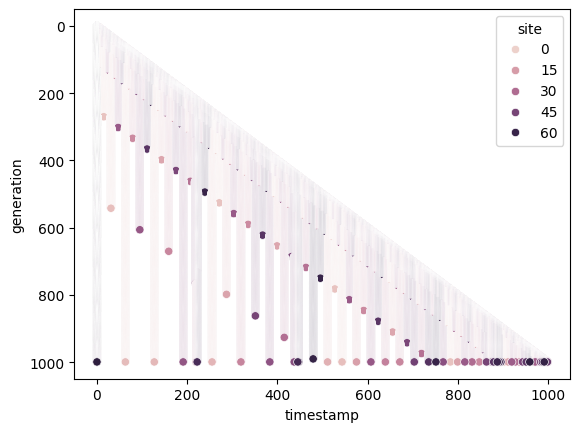

In [53]:
sns.scatterplot(
    data=surface_timestamps_df,
    x="timestamp",
    y="generation",
    hue="site",
).invert_yaxis()

pylib.jupyter_hide_toggle()


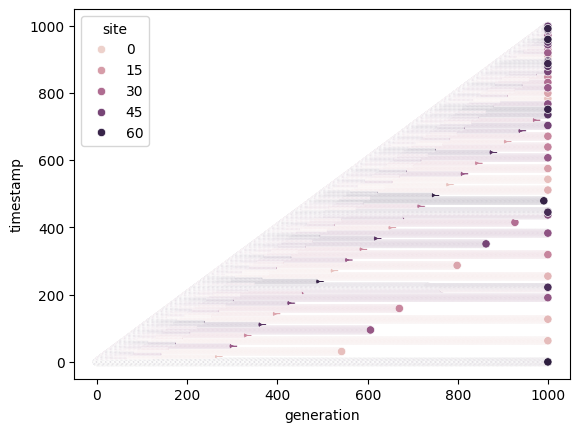

In [54]:
sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="timestamp",
    hue="site",
)

pylib.jupyter_hide_toggle()


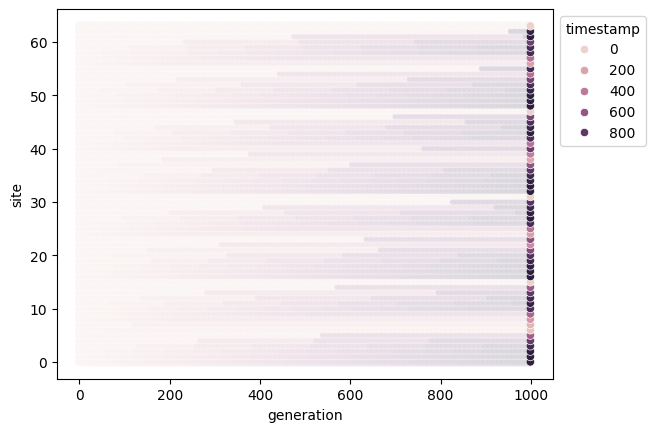

In [55]:
ax = sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="site",
    hue="timestamp",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

pylib.jupyter_hide_toggle()


# 16-bit surface


In [56]:
surface_size = 16
num_generations = 135

surface_timestamps = [0] * surface_size
surface_values = [random.choice([0, 1]) for __ in range(surface_size)]

pylib.jupyter_hide_toggle()


In [57]:
surface_timestamps_records = []
for generation in tqdm(range(num_generations)):
    target_site = get_deposition_site_at_rank(generation, surface_size)
    surface_values[target_site] = random.choice([0, 1])
    surface_timestamps[target_site] = generation

#     assert [
#         get_deposition_rank_at_site(site, surface_size, generation + 1)
#         for site in range(surface_size)
#     ] == surface_timestamps

    for site, timestamp in enumerate(surface_timestamps):
        surface_timestamps_records.append(
            {
                "generation": generation,
                "site": site,
                "timestamp": timestamp,
            }
        )

pylib.jupyter_hide_toggle()


100%|██████████| 135/135 [00:00<00:00, 55725.92it/s]


In [58]:
surface_timestamps_df = pd.DataFrame.from_records(surface_timestamps_records)
surface_timestamps_df

pylib.jupyter_hide_toggle()


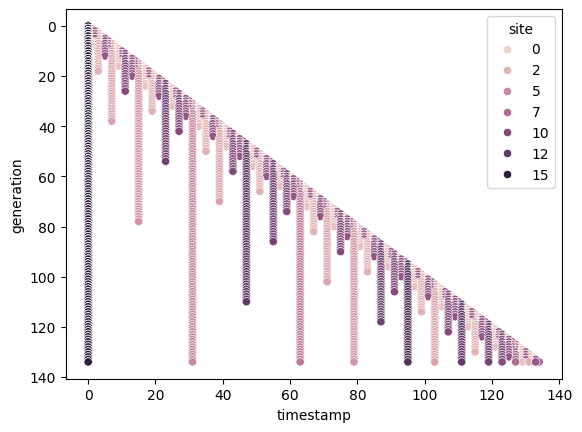

In [59]:
sns.scatterplot(
    data=surface_timestamps_df,
    x="timestamp",
    y="generation",
    hue="site",
).invert_yaxis()

pylib.jupyter_hide_toggle()


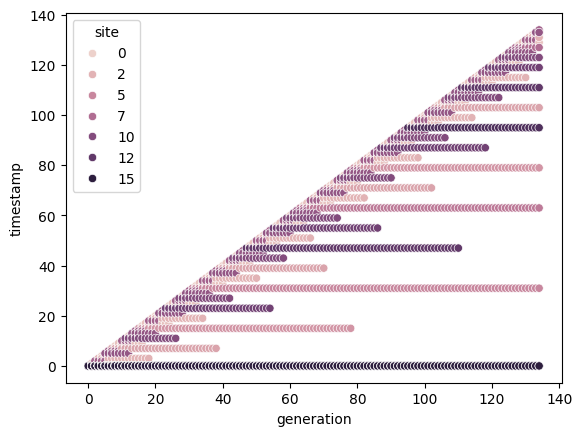

In [60]:
sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="timestamp",
    hue="site",
)

pylib.jupyter_hide_toggle()


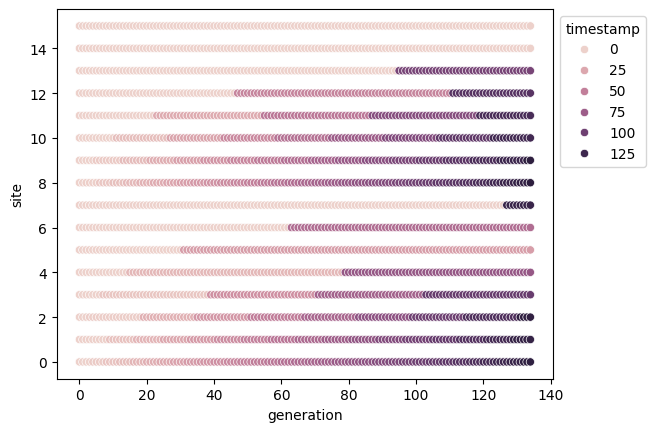

In [61]:
ax = sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="site",
    hue="timestamp",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

pylib.jupyter_hide_toggle()


# 8-bit surface


In [62]:
surface_size = 8
num_generations = 50

surface_timestamps = [0] * surface_size
surface_values = [random.choice([0, 1]) for __ in range(surface_size)]

pylib.jupyter_hide_toggle()


In [63]:
surface_timestamps_records = []
for generation in tqdm(range(num_generations)):
    target_site = get_deposition_site_at_rank(generation, surface_size)
    surface_values[target_site] = random.choice([0, 1])
    surface_timestamps[target_site] = generation

#     assert [
#         get_deposition_rank_at_site(site, surface_size, generation + 1)
#         for site in range(surface_size)
#     ] == surface_timestamps

    for site, timestamp in enumerate(surface_timestamps):
        surface_timestamps_records.append(
            {
                "generation": generation,
                "site": site,
                "timestamp": timestamp,
            }
        )

pylib.jupyter_hide_toggle()


100%|██████████| 50/50 [00:00<00:00, 40896.10it/s]


In [64]:
surface_timestamps_df = pd.DataFrame.from_records(surface_timestamps_records)
surface_timestamps_df

pylib.jupyter_hide_toggle()


In [65]:
def scatter_invert(*args, **kwargs):
    ax = sns.scatterplot(*args, **kwargs)
    ax.invert_yaxis()


teeplots/04/hue=site+viz=scatter-invert+x=timestamp+y=generation+ext=.pdf
teeplots/04/hue=site+viz=scatter-invert+x=timestamp+y=generation+ext=.png


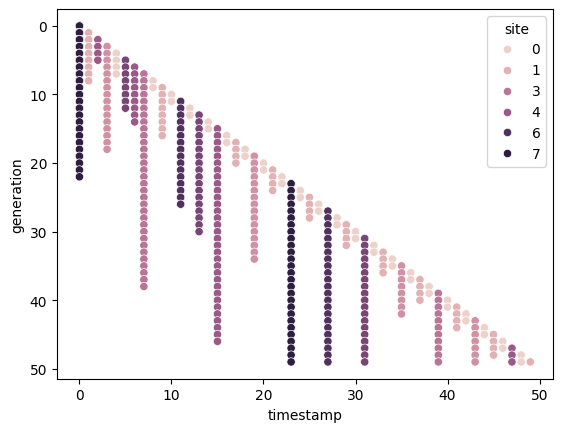

In [66]:
pylib.tee_release(
    scatter_invert,
    data=surface_timestamps_df,
    x="timestamp",
    y="generation",
    hue="site",
    teeplot_subdir="04",
)

pylib.jupyter_hide_toggle()


teeplots/04/hue=site+viz=scatterplot+x=generation+y=timestamp+ext=.pdf
teeplots/04/hue=site+viz=scatterplot+x=generation+y=timestamp+ext=.png


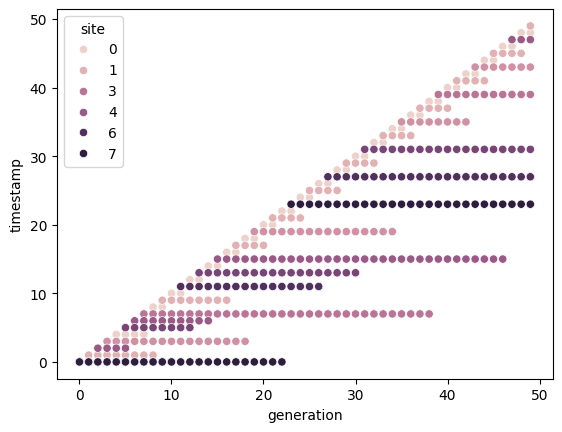

In [67]:
pylib.tee_release(
    sns.scatterplot,
    data=surface_timestamps_df,
    x="generation",
    y="timestamp",
    hue="site",
    teeplot_subdir="04",
)

pylib.jupyter_hide_toggle()


In [68]:
def scatterplot_legout(*args, **kwargs):
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


teeplots/04/hue=timestamp+viz=scatterplot-legout+x=generation+y=site+ext=.pdf
teeplots/04/hue=timestamp+viz=scatterplot-legout+x=generation+y=site+ext=.png


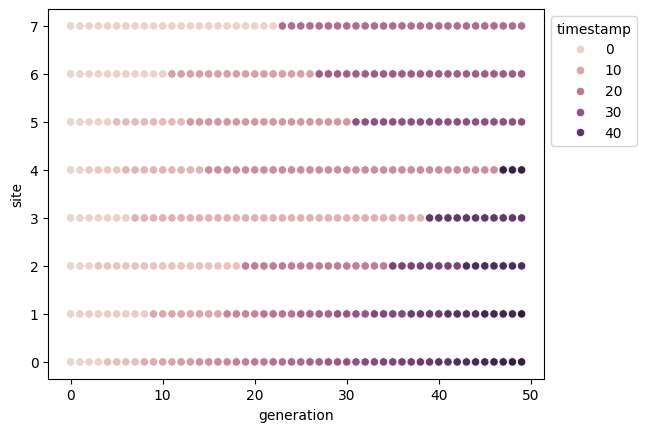

In [69]:
pylib.tee_release(
    scatterplot_legout,
    data=surface_timestamps_df,
    x="generation",
    y="site",
    hue="timestamp",
    teeplot_subdir="04",
)

pylib.jupyter_hide_toggle()


# Visualize


In [70]:
def get_surface_rank_capacity(surface_size: int) -> int:
    return pylib.hanoi.get_index_of_hanoi_value_nth_incidence(surface_size, 0)


100%|██████████| 127/127 [00:00<00:00, 60807.83it/s]


teeplots/04/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


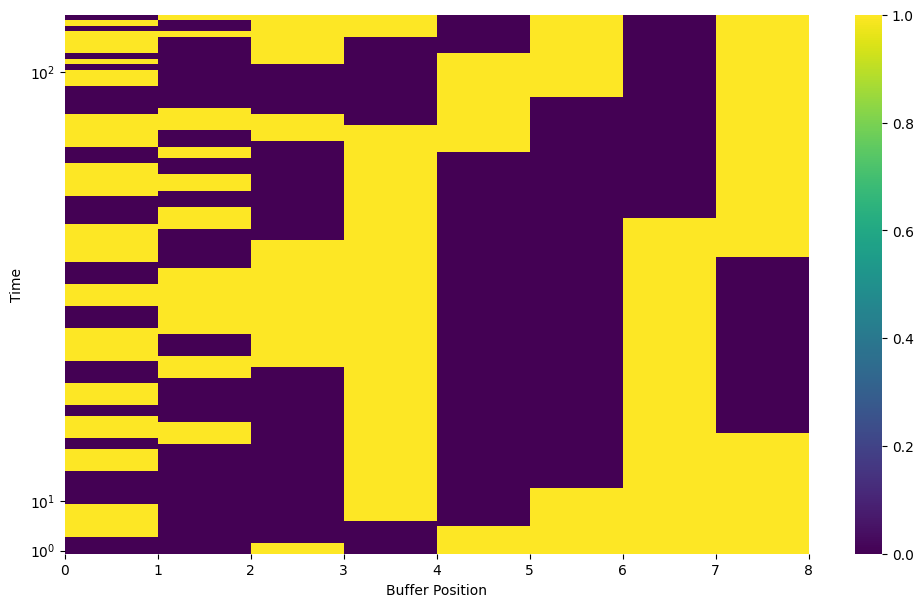

teeplots/04/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


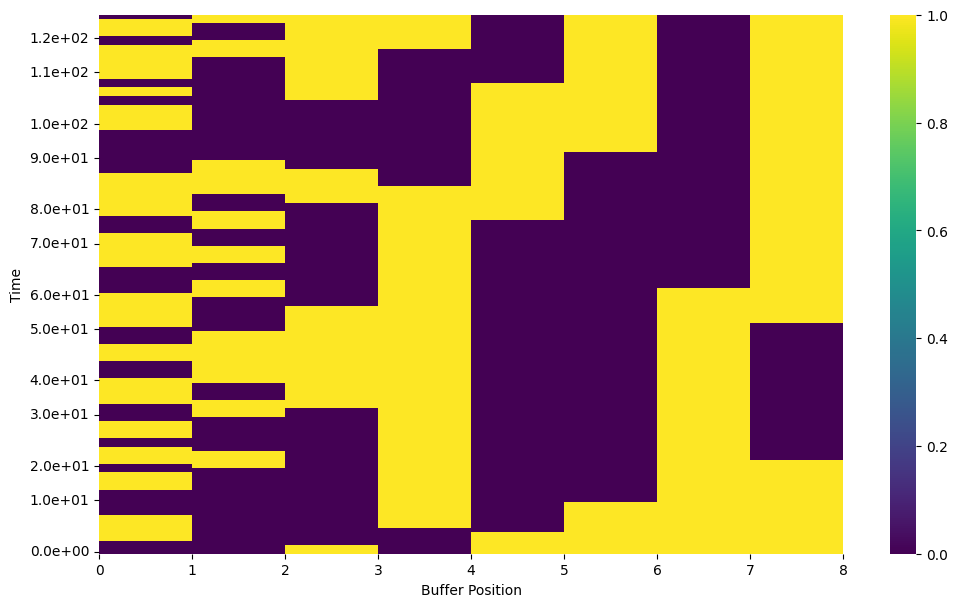

teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


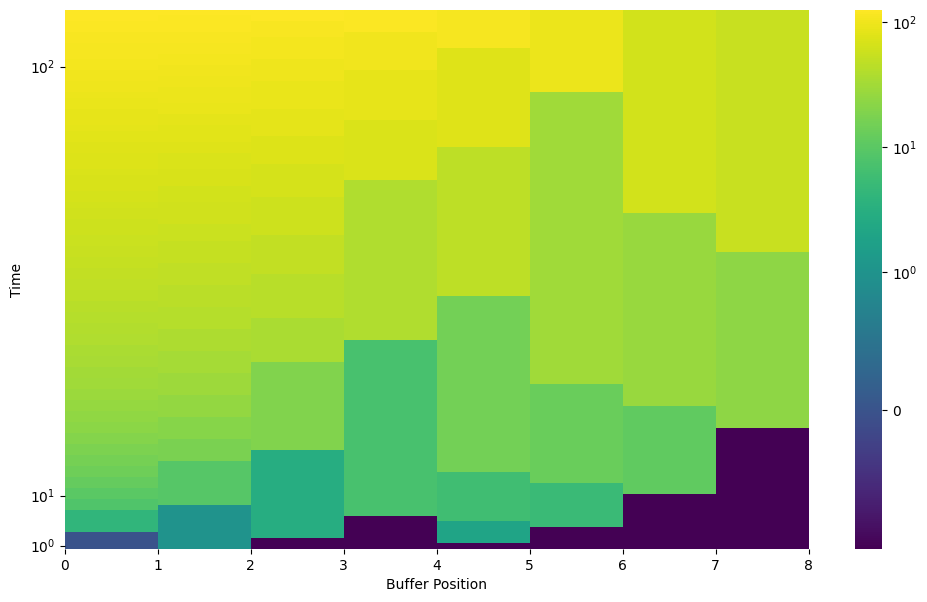

teeplots/04/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


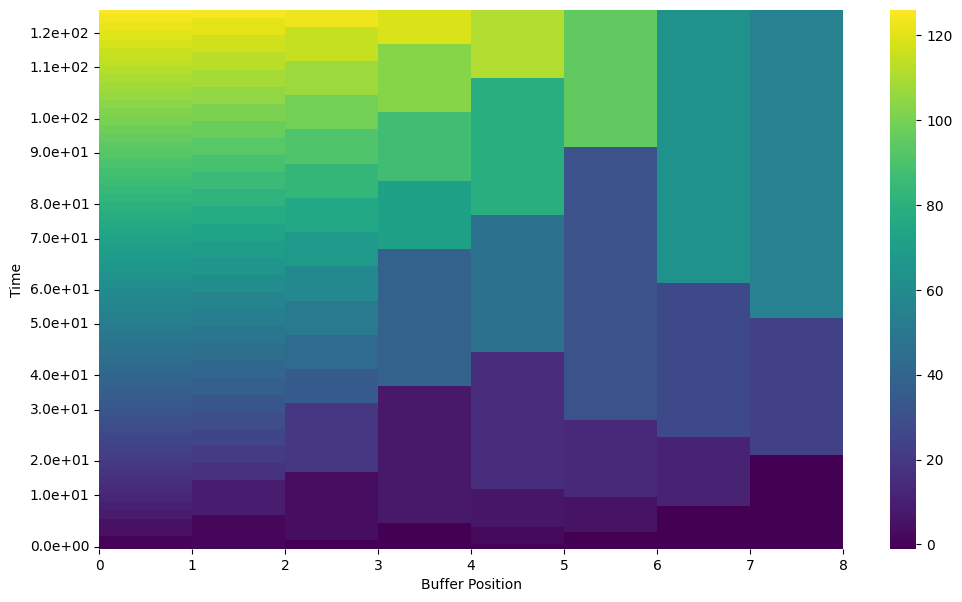

teeplots/04/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/04/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.png


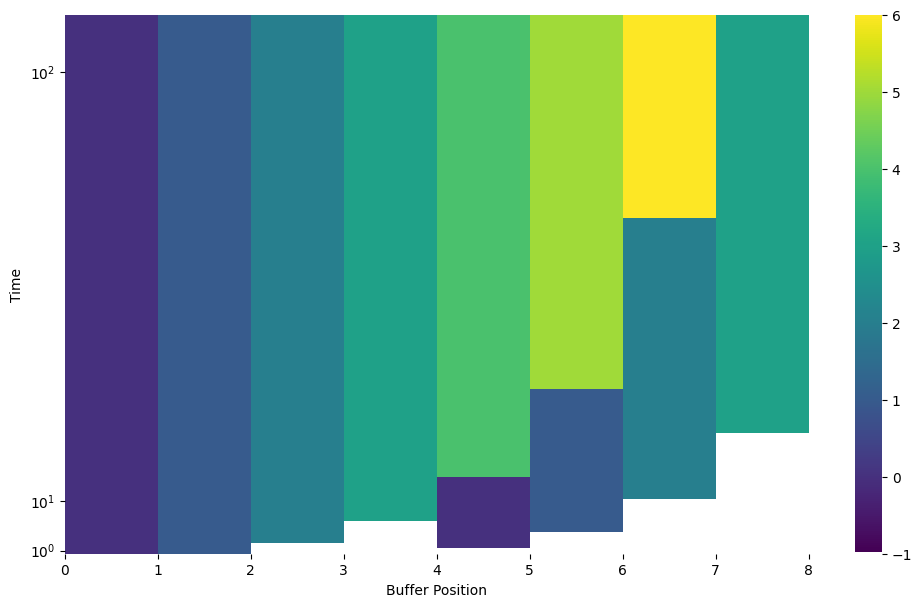

teeplots/04/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


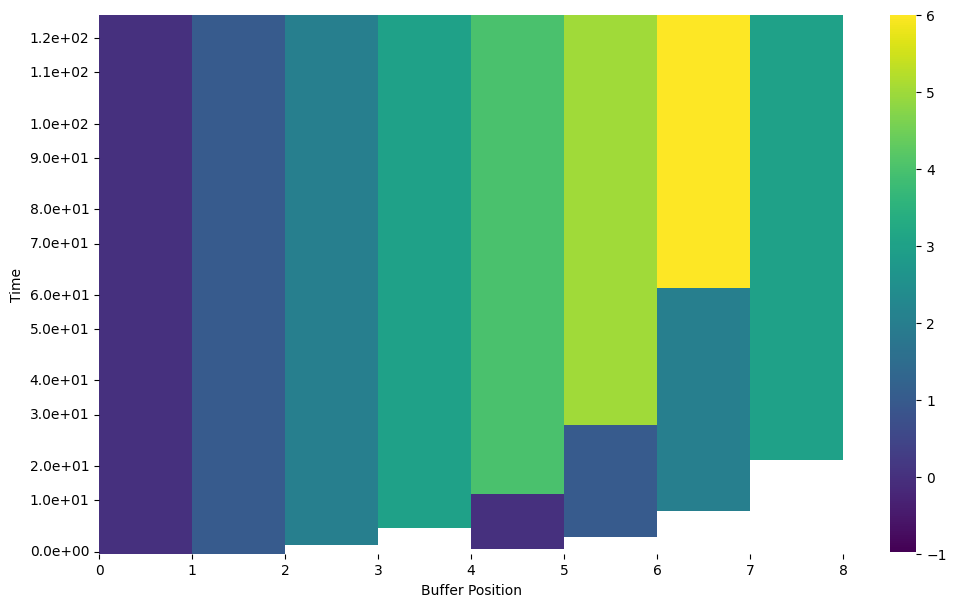

teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


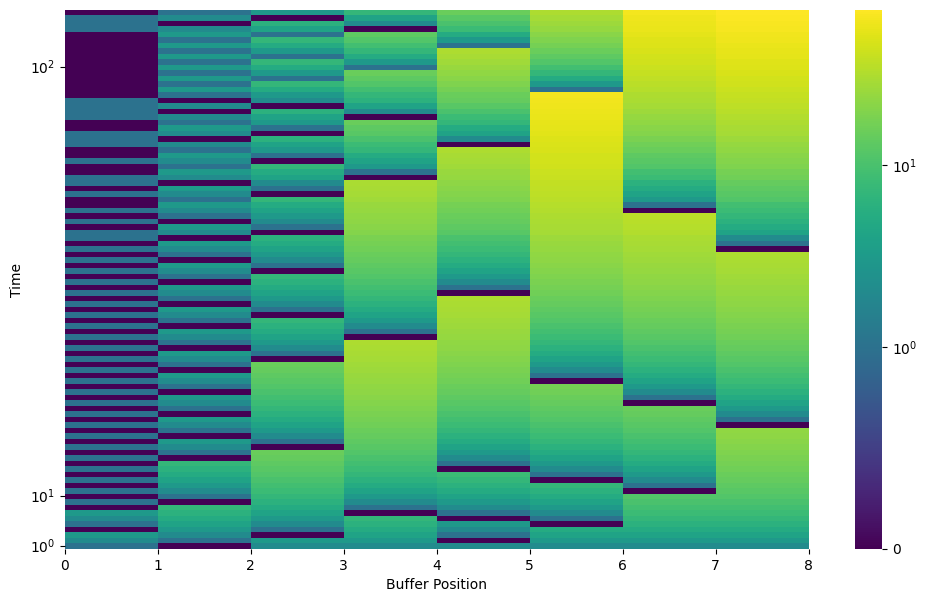

teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


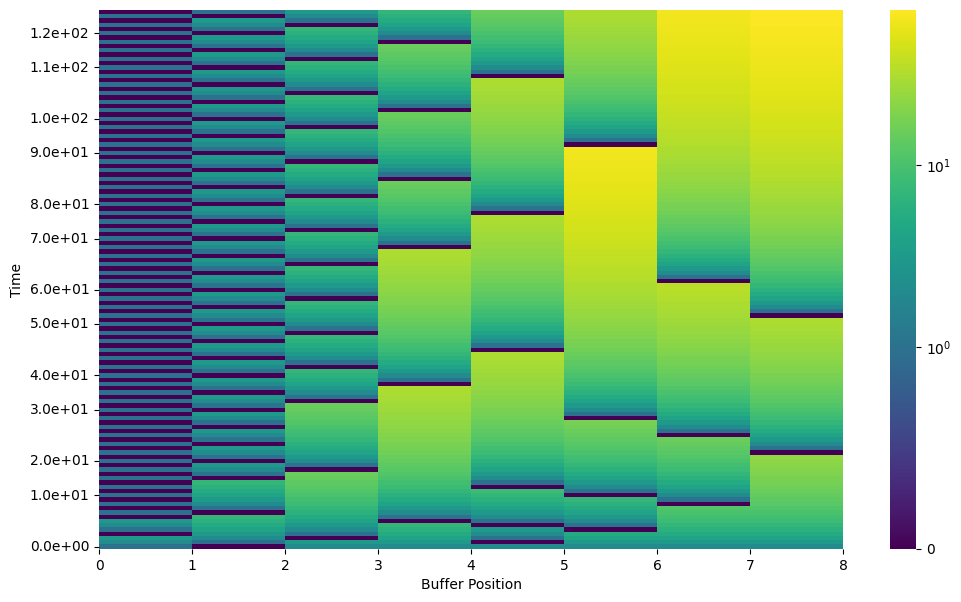

100%|██████████| 125/125 [00:00<00:00, 366.16it/s]


teeplots/04/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/04/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.png


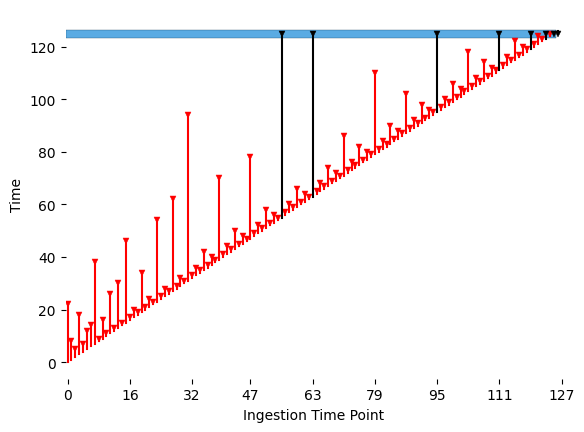

100%|██████████| 262144/262144 [00:06<00:00, 38854.20it/s]


teeplots/04/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


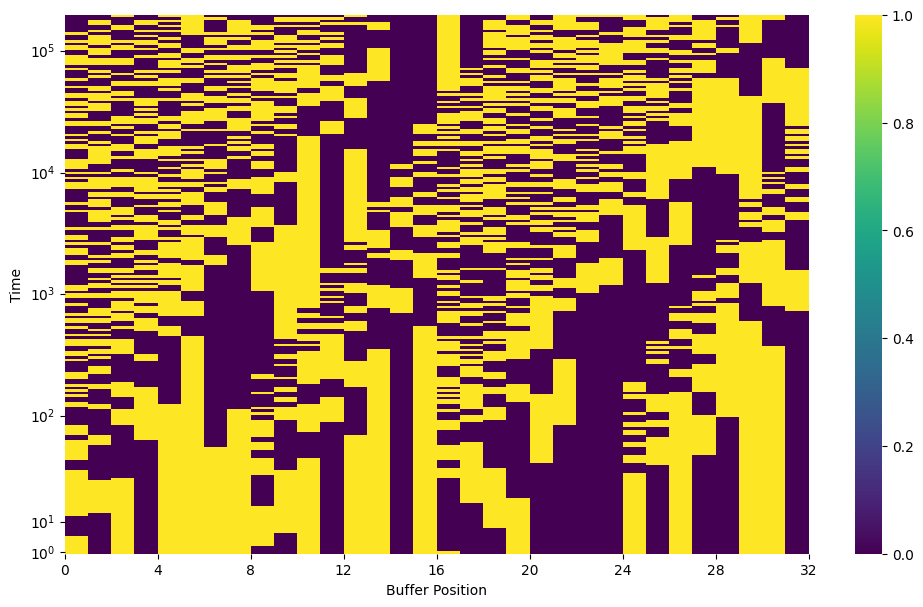

teeplots/04/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


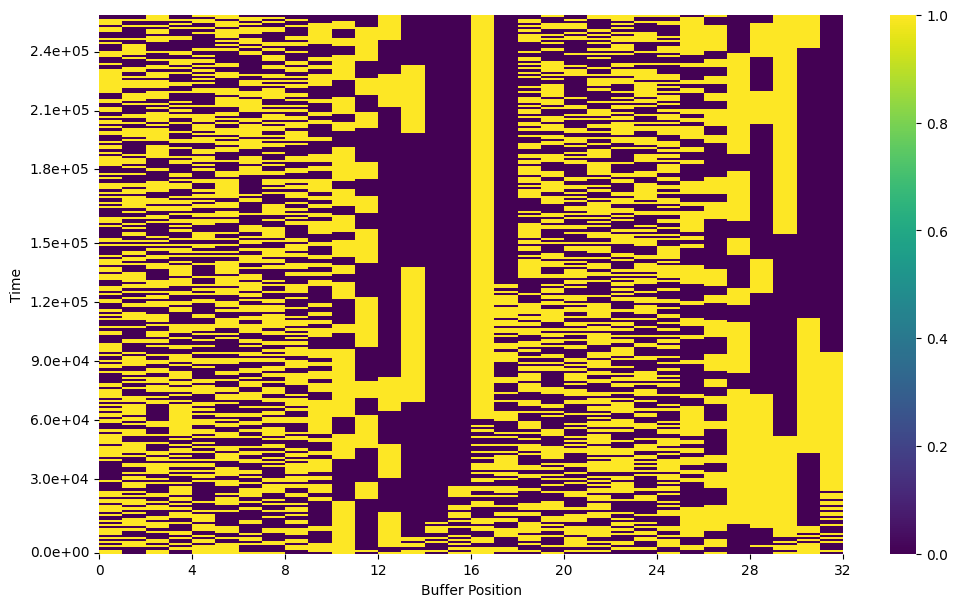

teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


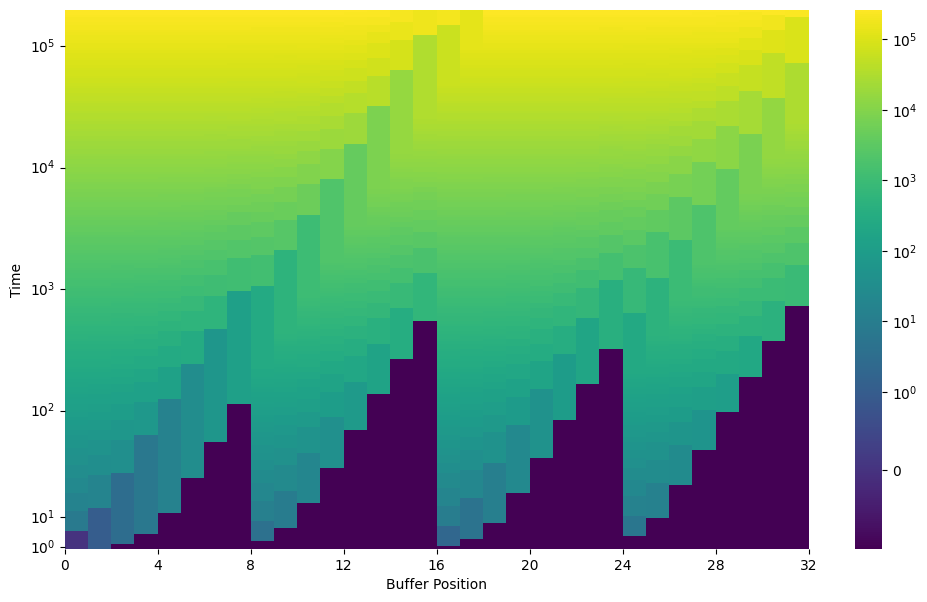

teeplots/04/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


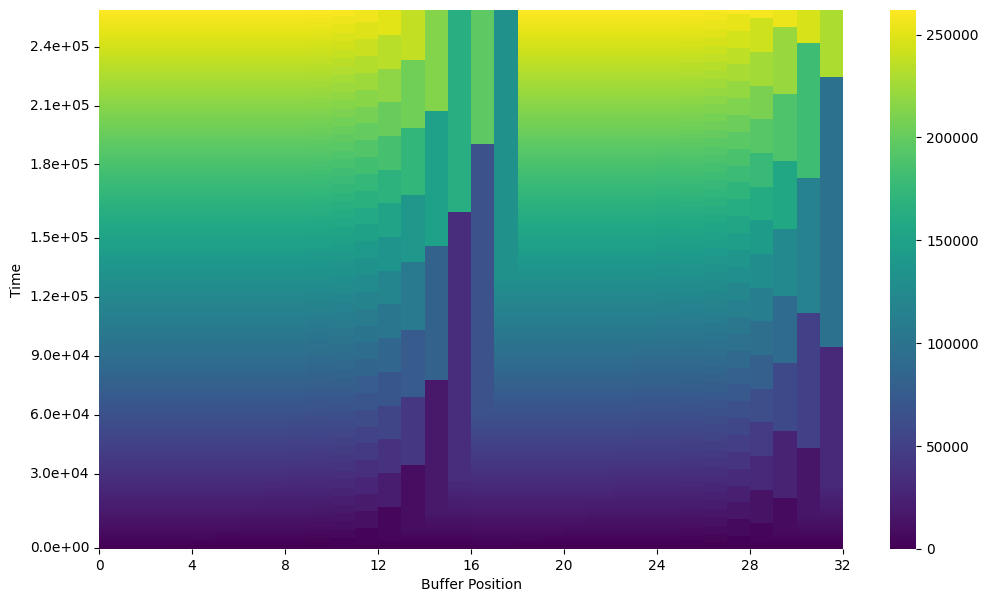

teeplots/04/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/04/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.png


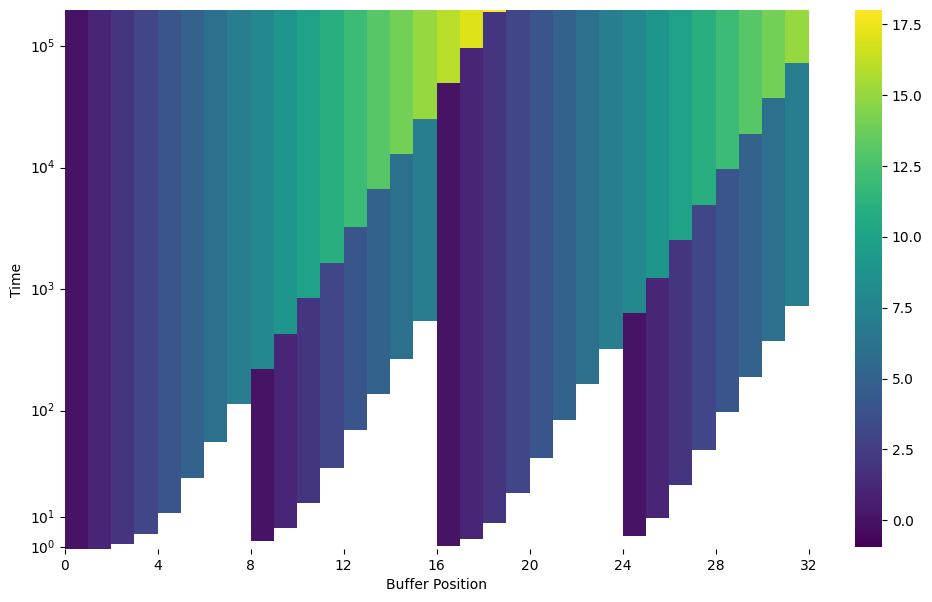

teeplots/04/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


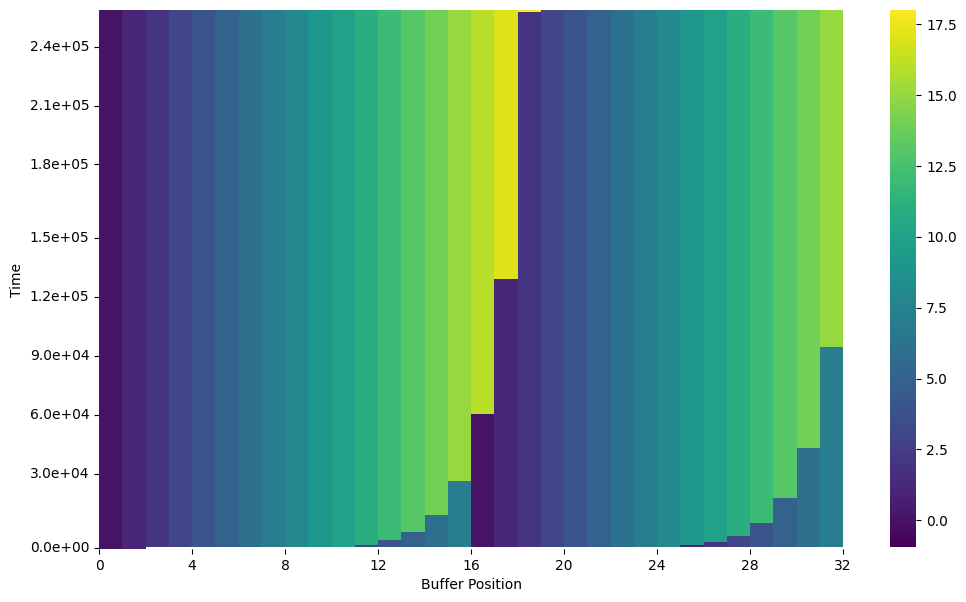

teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


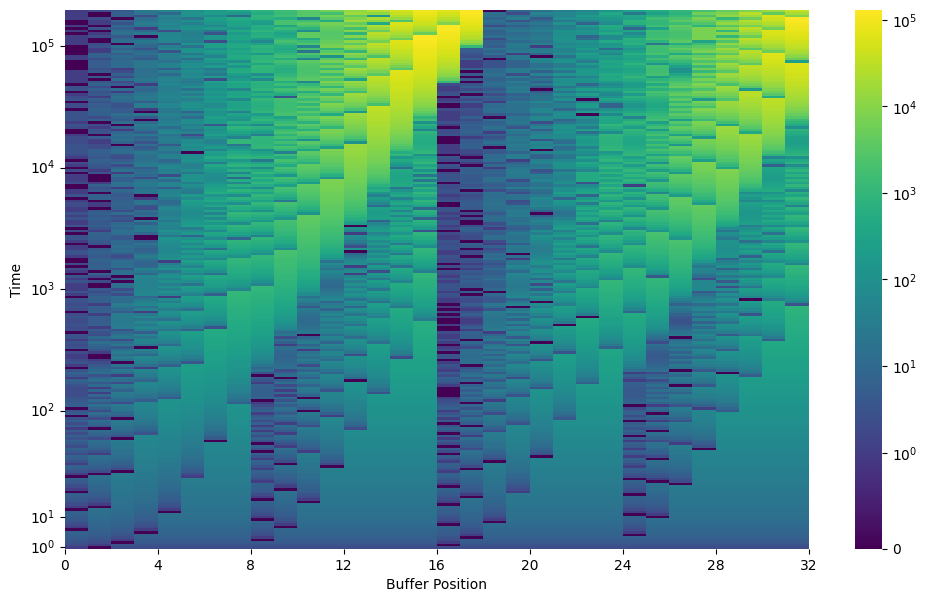

teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


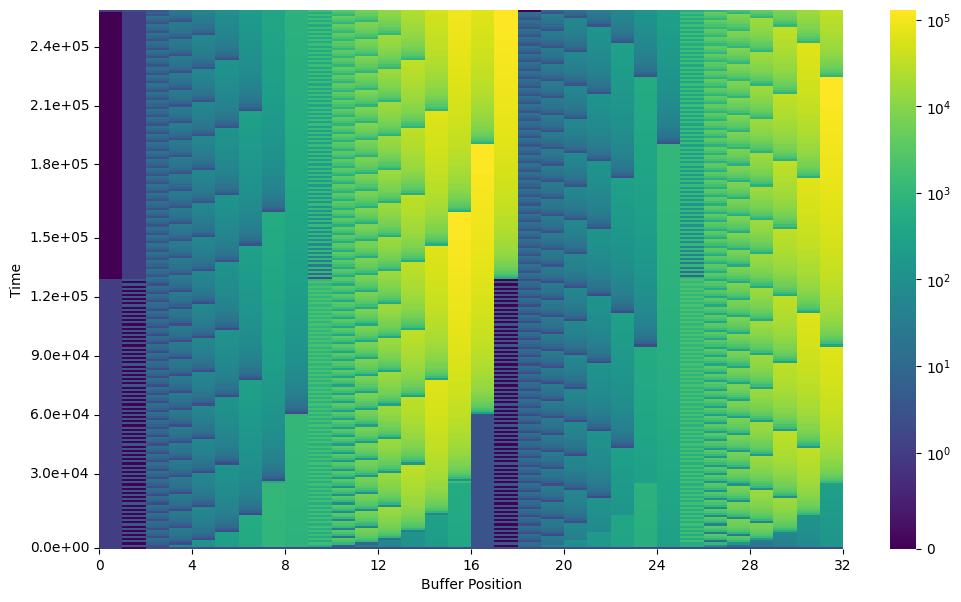

100%|██████████| 2998/2998 [00:07<00:00, 375.54it/s]


teeplots/04/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/04/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.png


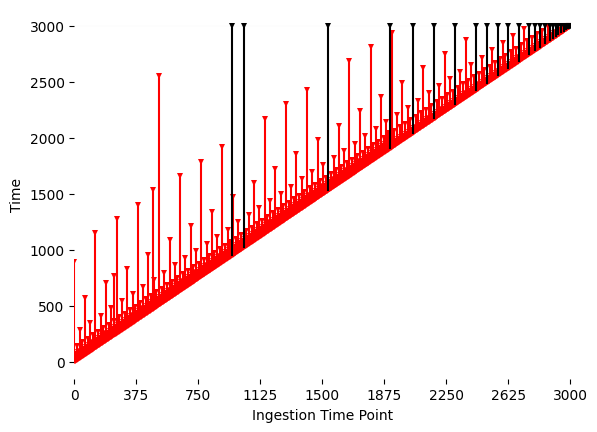

100%|██████████| 4096/4096 [00:00<00:00, 17071.70it/s]


teeplots/04/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


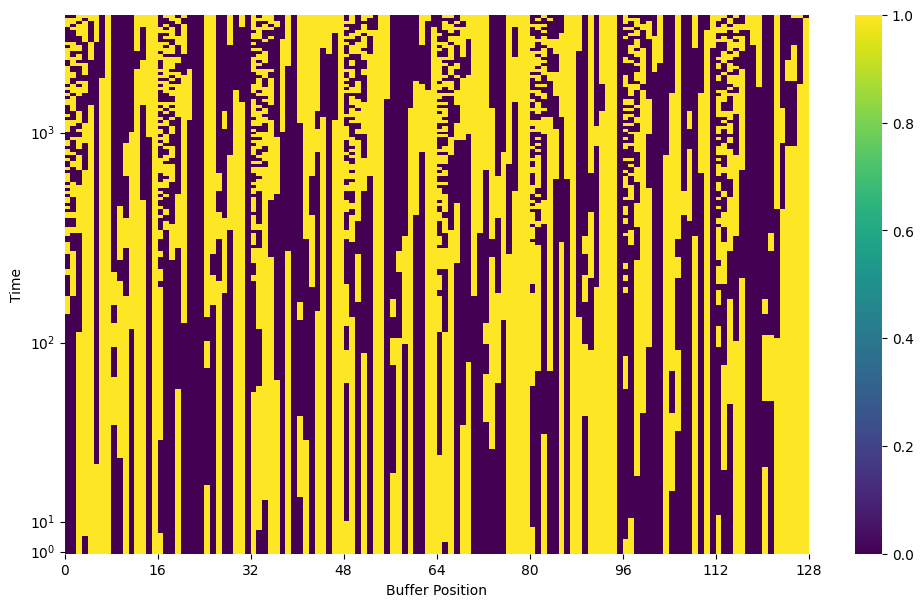

teeplots/04/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


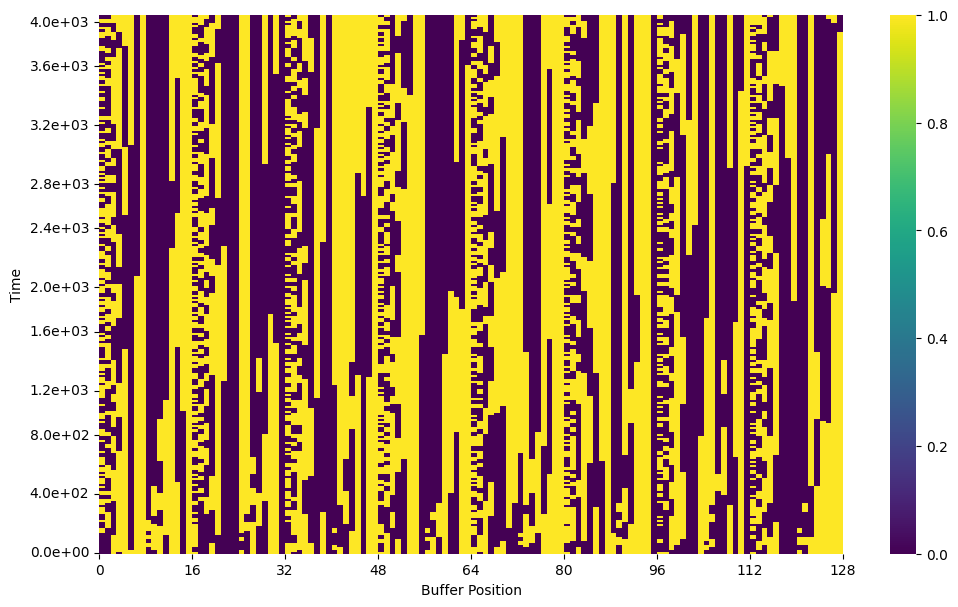

teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


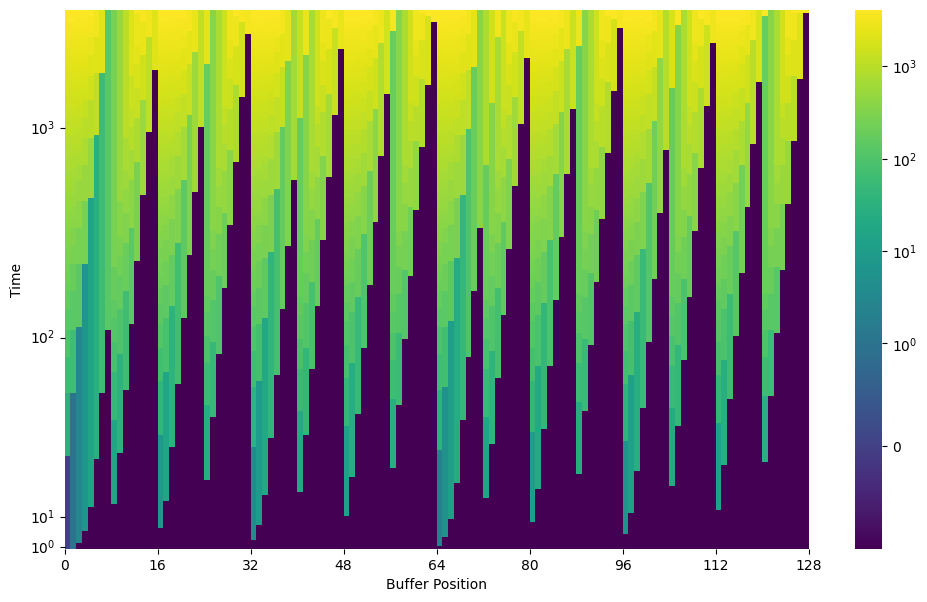

teeplots/04/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


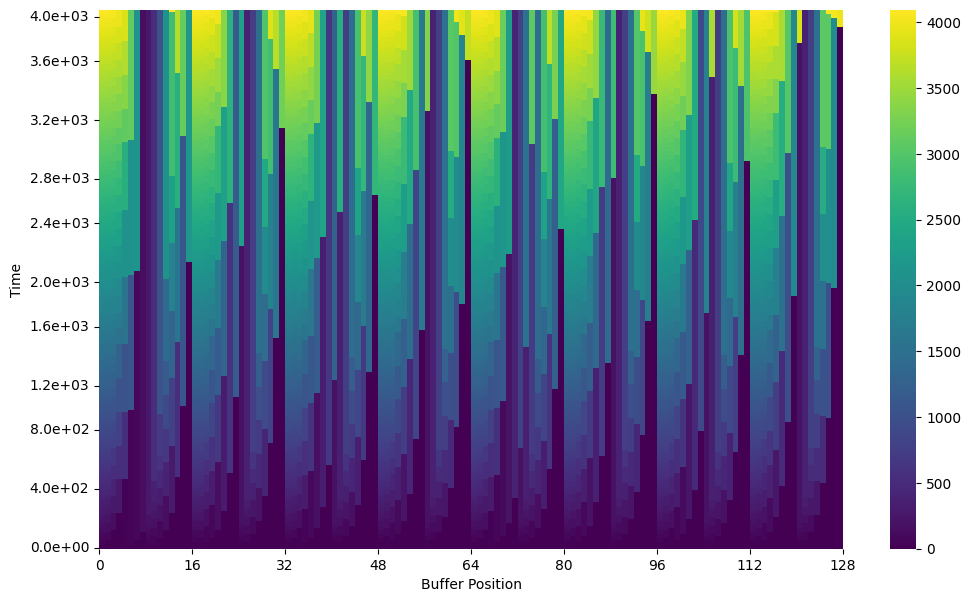

teeplots/04/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/04/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.png


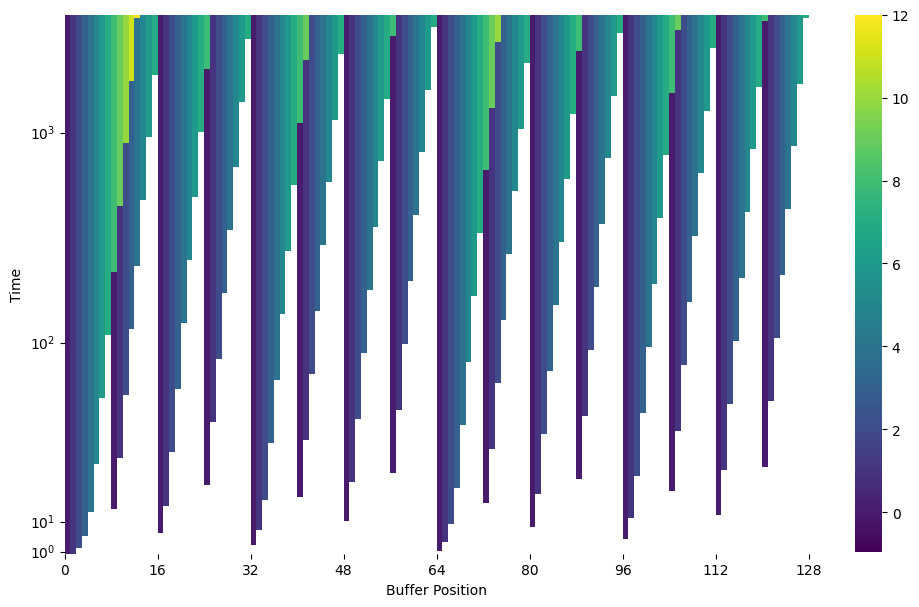

teeplots/04/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


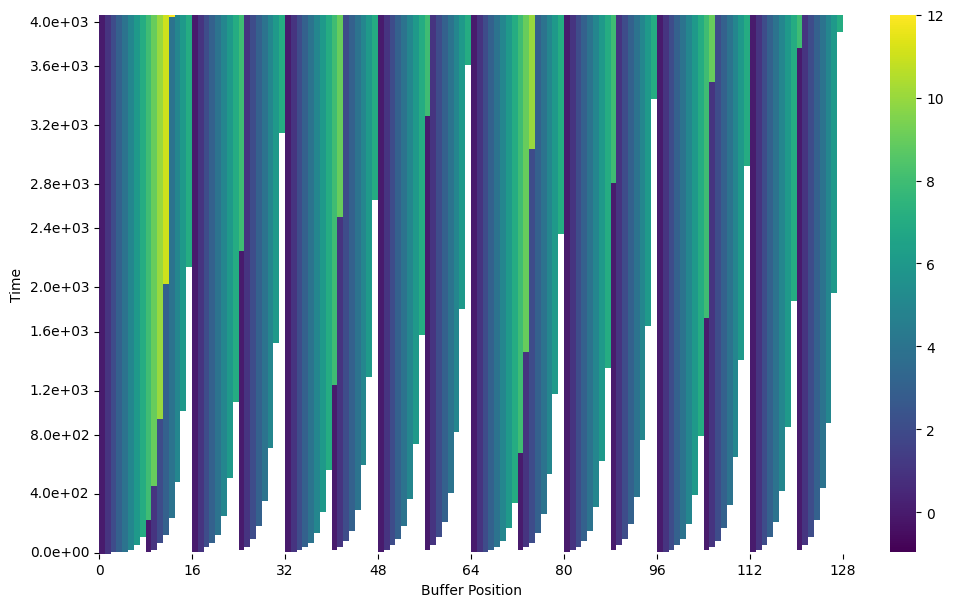

teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


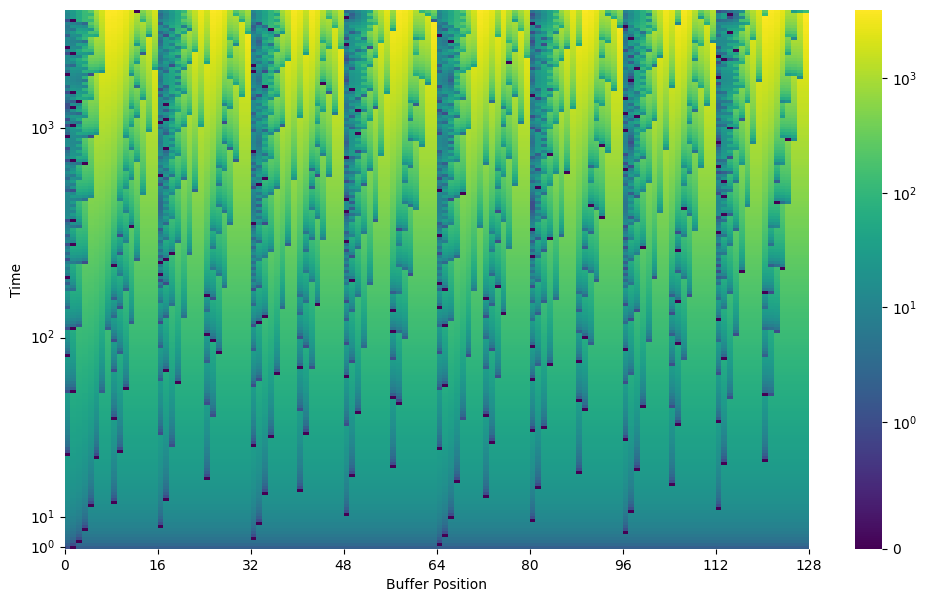

teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


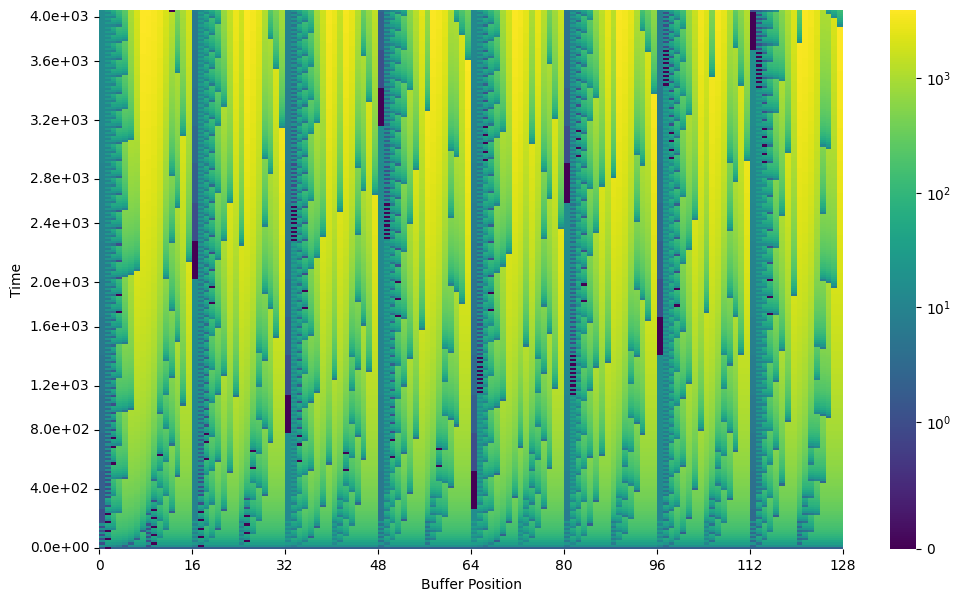

100%|██████████| 2998/2998 [00:09<00:00, 323.42it/s]


teeplots/04/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/04/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.png


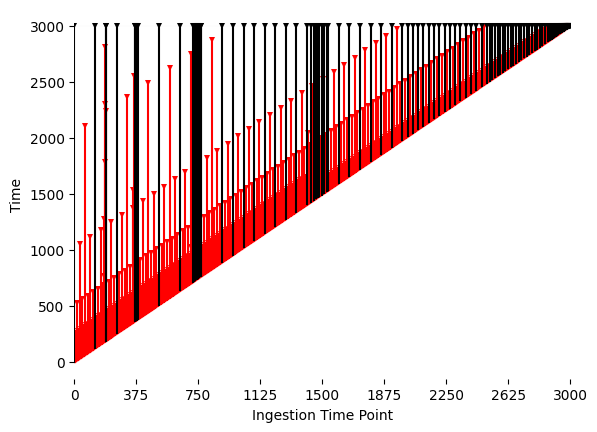

100%|██████████| 4096/4096 [00:00<00:00, 4809.50it/s]


teeplots/04/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


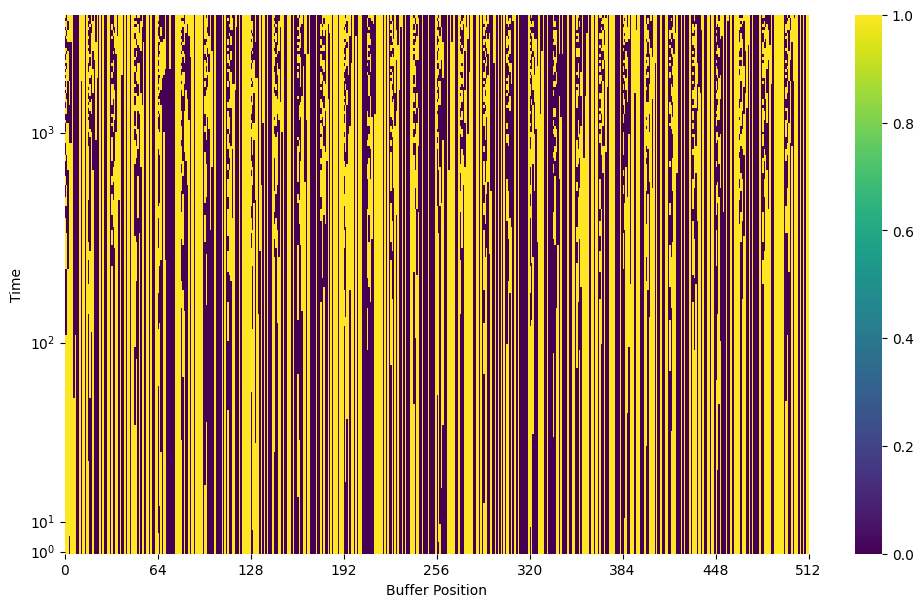

teeplots/04/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


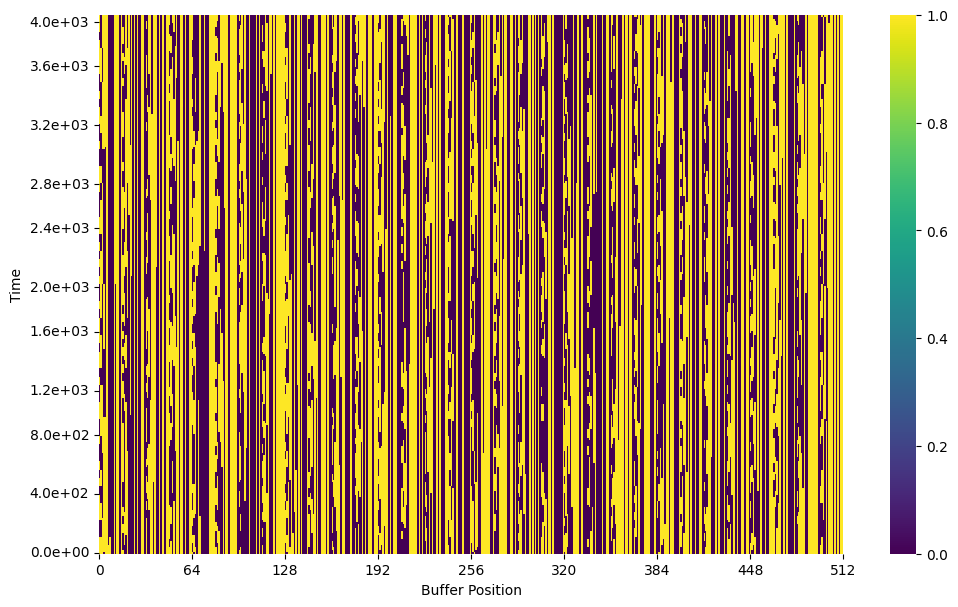

teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


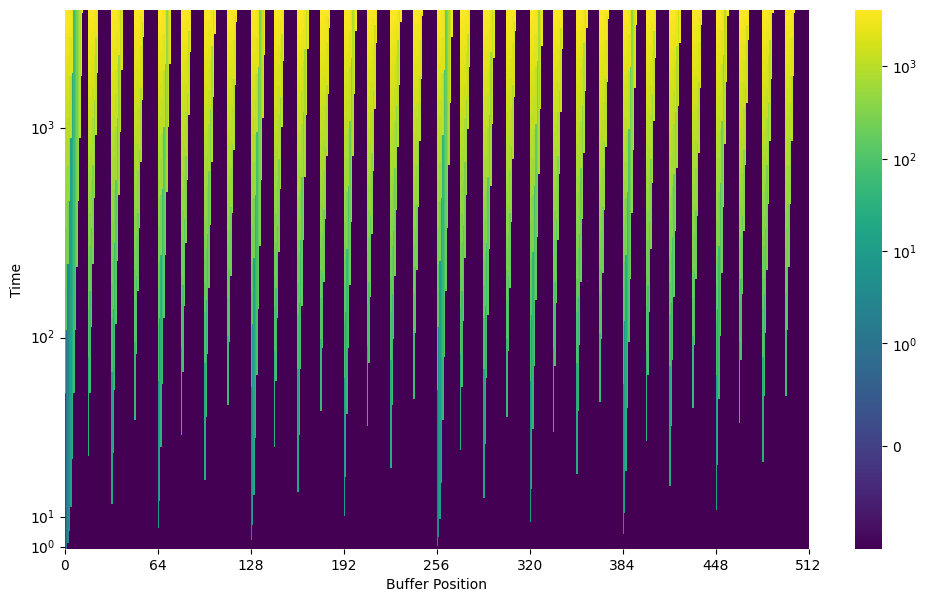

teeplots/04/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


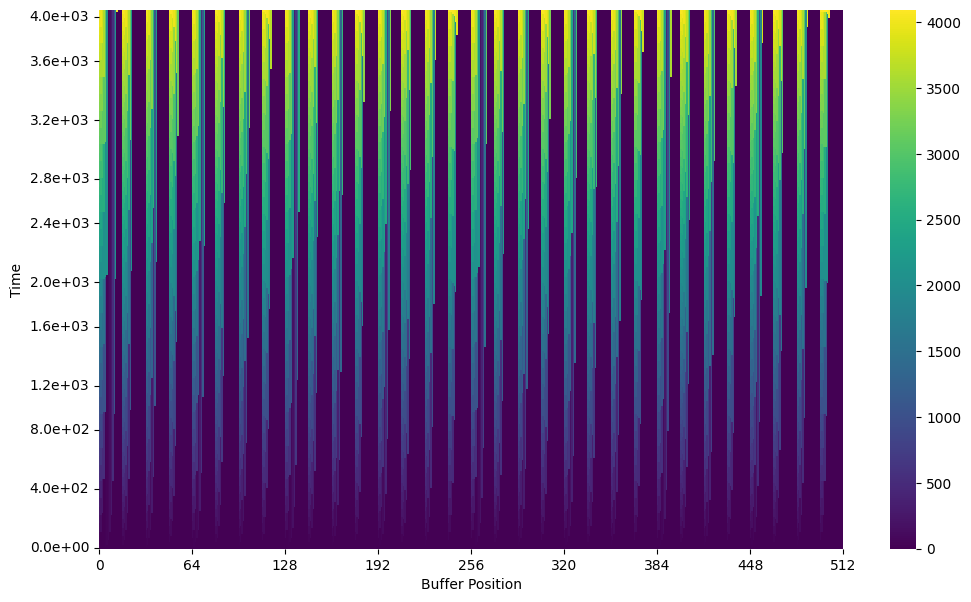

teeplots/04/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/04/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.png


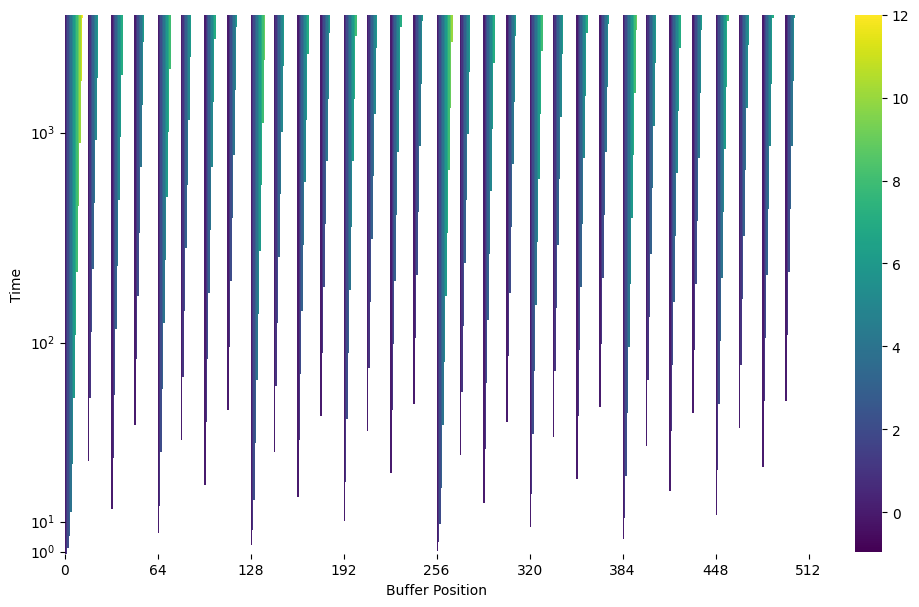

teeplots/04/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


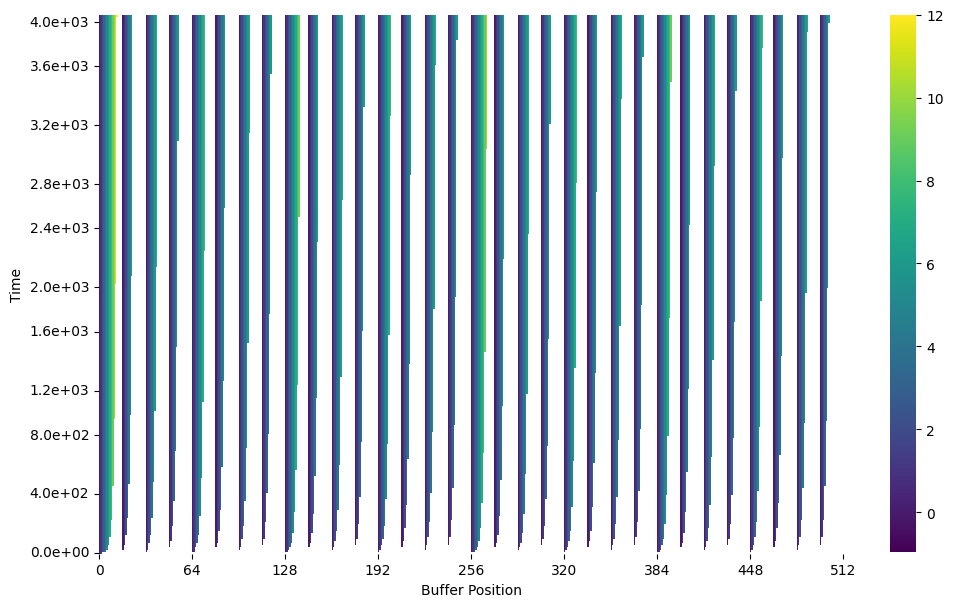

teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


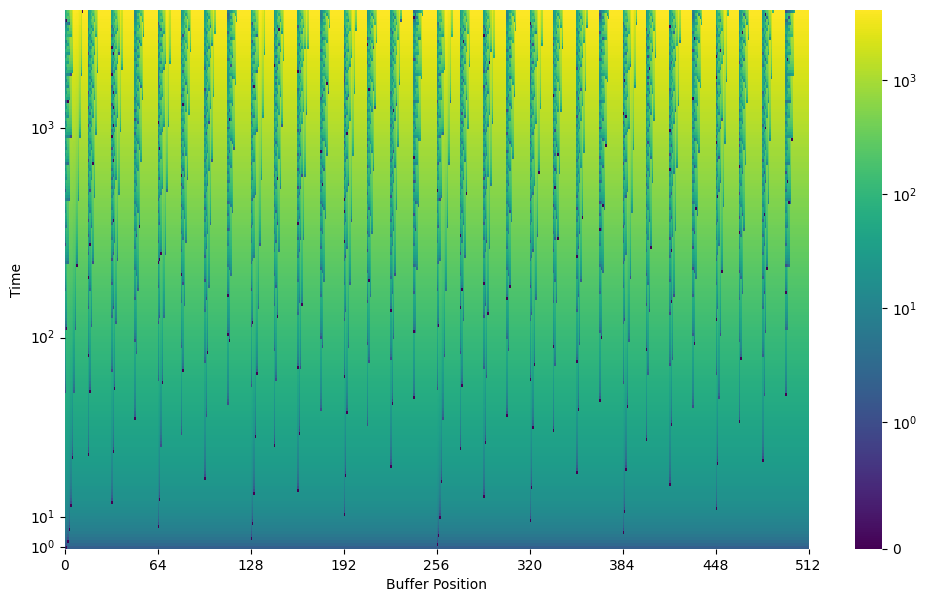

teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/04/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


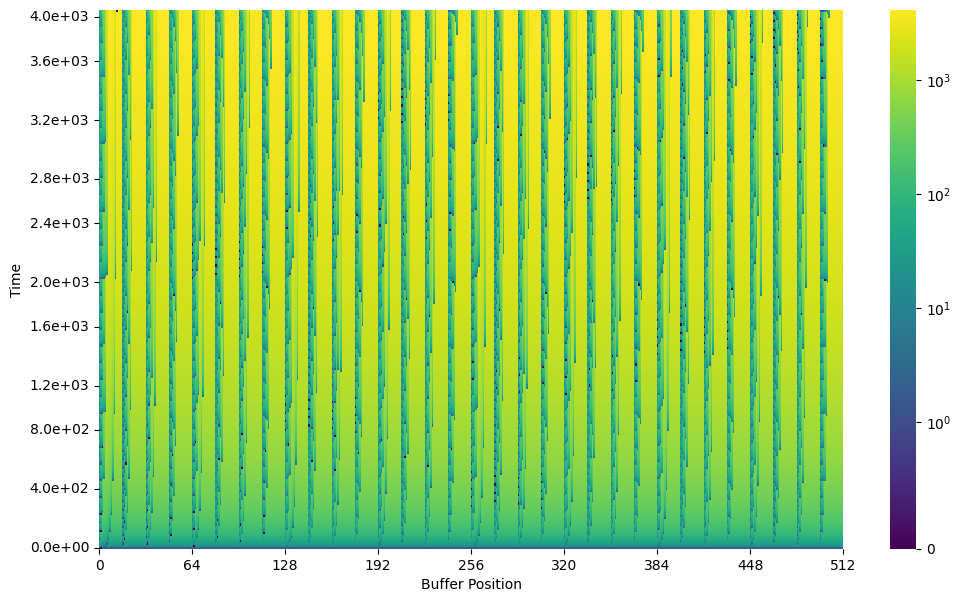

100%|██████████| 2998/2998 [00:14<00:00, 210.92it/s]


teeplots/04/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/04/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.png


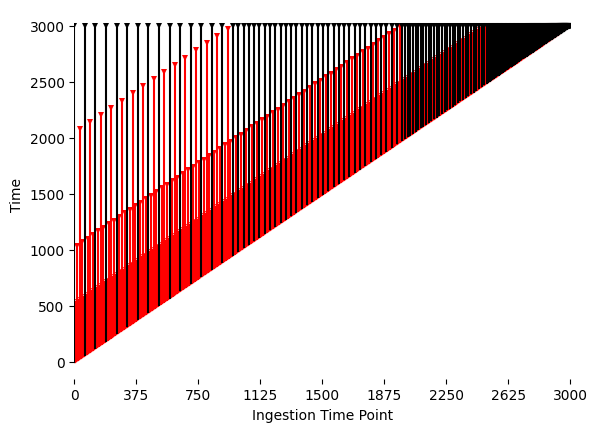

In [71]:
for surface_size_exp in range(3, 10, 2):
    surface_size = 2**surface_size_exp
    display(HTML(f"<h3>surface size {surface_size}</h3>"))

    num_generations = min(
        # don't run out of memory
        2**18 if surface_size_exp < 7 else 2**12,
        get_surface_rank_capacity(surface_size - 1),
    )

    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        get_deposition_site_at_rank,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    )

    # ========================
    kwargs = dict(
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        cnorm=None,
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="04",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.stratum_persistence_dripplot,
        surface_history_df[surface_history_df["rank"] < 3000],
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        progress_wrap=tqdm,
        teeplot_subdir="04",
    )
